In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

## Plot variance & peaks per experiment and correlation & peak overlap between experiments

In [4]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
win_size_kb = 5
bin_size = 20

CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"

v_in = {}
v_out = {}
h_in = {}
h_out = {}

for my_tf in TFs:
    print(my_tf)
    
    # get TF tensor
    infile = f'../results/{genome}/Chip_tensors/Window_pm{win_size_kb}kb_bin_size_{bin_size}/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        X = hf['chip_prom_pos_exp'][:]
        my_ids = hf['chip_prom_pos_exp'].attrs['exp_id'].split(',')

    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    # replace nans with 0s
    X[np.isnan(X)] = 0
    N_prom, N_pos, N_exp = X.shape
    X_flat = X.reshape([N_prom*N_pos,N_exp])
        
    # get peaks tensor
    infile = f'../results/mm10/Peak_tensors/Window_pm{win_size_kb}kb/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        Peaks = hf['peak_prom_pos_exp'][:]

    # get binned tensor
    Peaks_binned = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)
    Peaks_binned_flat = Peaks_binned.reshape([N_prom*N_pos,N_exp])

    N_bin = 100
    for i in range(N_exp):
        v_in[my_ids[i]] = np.nanvar(X_flat[Peaks_binned_flat[:,i],i])
        v_out[my_ids[i]] = np.nanvar(X_flat[~Peaks_binned_flat[:,i],i])
        h_in[my_ids[i]] = np.histogram(X_flat[Peaks_binned_flat[:,i],i],bins=N_bin)
        h_out[my_ids[i]] = np.histogram(X_flat[~Peaks_binned_flat[:,i],i],bins=N_bin)


E2f1
Mnt
Sox4
Pou2af1
Bach1
E2f3
Fosb
Otx2
Pbx1
Pax7


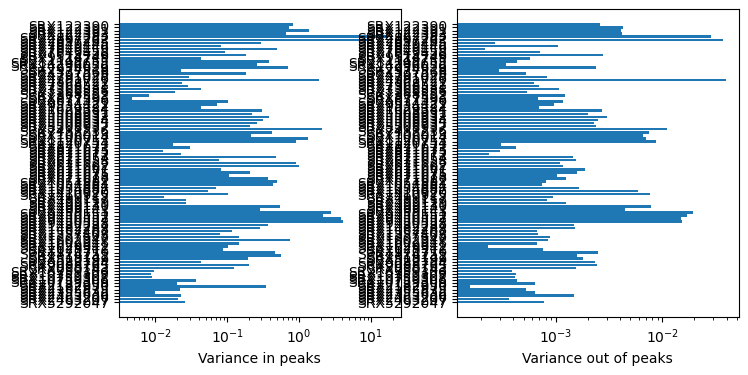

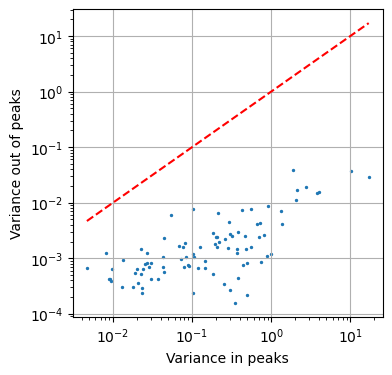

In [5]:
v_in = pd.Series(v_in)
v_out = pd.Series(v_out)

fig, axes = plt.subplots(1,2,figsize=(8,4))
ax = axes[0]
ax.barh(v_in.index,v_in.values)
ax.set_xlabel('Variance in peaks')
ax.invert_yaxis()
ax.set_xscale('log')

ax = axes[1]
ax.barh(v_out.index,v_out.values)
ax.set_xlabel('Variance out of peaks')
ax.invert_yaxis()
ax.set_xscale('log')

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot([v_in.min(),v_in.max()],[v_in.min(),v_in.max()],'r--')
ax.scatter(v_in.values,v_out.values,s=2)
ax.set_xlabel('Variance in peaks')
ax.set_ylabel('Variance out of peaks')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
if False:
    n = int(np.ceil(np.sqrt(len(h_in))))
    fig, axes = plt.subplots(n,n,figsize=(4*n,4*n))
    for i,id in enumerate(h_in):
        ax = axes.flatten()[i]
        ax.plot((h_in[id][1][:-1]+h_in[id][1][1:])/2,h_in[id][0],'.',label='in peaks')
        ax.plot((h_out[id][1][:-1]+h_out[id][1][1:])/2,h_out[id][0],'.',label='out of peaks')
        ax.set_yscale('log')
        ax.set_title(id)




## Quantile norm of TF ChIP signal

In [ ]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']

# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"

X = np.zeros([0,0,0])
for my_tf in TFs:
    print(my_tf)
    
    # get TF tensor
    infile = f'../results/{genome}/Chip_tensors/Window_pm{win_size_kb}kb_bin_size_{bin_size}/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        my_ids = [i.decode('utf-8') for i in hf['experiment_id'][:]]
        x = hf['chip_prom_pos_exp'][:]
    
    if X.size == 0:
        X = x
    else:
        X = np.concatenate([X,x],axis=2)

: 

In [ ]:
X = X.reshape([X.shape[0]*X.shape[1],X.shape[2]])

: 

In [ ]:

bins = np.logspace(-1,np.log10(X[~np.isnan(X)].max()),50)
#bins = np.linspace(0,X[~np.isnan(X)].max(),50)
dx = np.diff(bins)
H = np.zeros([len(bins)-1,X.shape[1]])
for i in range(X.shape[1]):
    idx = ~np.isnan(X[:,i])
    H[:,i], tmp = np.histogram(X[idx,i],bins=bins,density=False)

# normalize
#H = H / dx[:,None] 
H = H / H.sum(axis=0)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot((bins[:-1]+bins[1:])/2,H)
ax.set_xscale('log')
ax.set_yscale('log')



: 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
h,x = np.histogram(np.log10( X[~np.isnan(X)] ),bins=100)

ax.plot((x[:-1]+x[1:])/2,h)
ax.set_yscale('log')

: 

# Truncated Gaussian fit

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import h5py
# import pycircstat
from collections import namedtuple
from scipy import stats

# PCA & PPCA
from sklearn.decomposition import PCA
#from ppca import *

# from models_cellcycle import *
import jax
import jax.numpy as jnp
from jax import random, vmap, jit
import numpy as np
import numpyro
import numpyro.distributions as dist

# from params import 

from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from numpyro.optim import Adam
# from numpyro.distributions import constraints
from numpyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoNormal
# import init_to_value
from numpyro.infer import init_to_value, init_to_feasible

from numpyro.infer import MCMC, NUTS, Predictive, HMCGibbs, DiscreteHMCGibbs, SA, reparam
from numpyro.distributions import TruncatedNormal,  NegativeBinomial2
from numpyro.infer import SVI, Trace_ELBO
from numpyro.optim import Adam


In [4]:
def truncated_normal_model(num_observations, x=None):
    loc = numpyro.param("loc", 0.0)
    scale = numpyro.param("scale", 1.0, constraint=dist.constraints.positive)
    low = numpyro.param("low", -1.0)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x", TruncatedNormal(loc, scale, low=low), obs=x)

def NegativeBinomial_model(num_observations, x=None):
    conc = numpyro.param("conc", 1.0, constraint=dist.constraints.positive)
    mean = numpyro.param("mean", 1.0, constraint=dist.constraints.positive)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x",  NegativeBinomial2(conc, mean), obs=x)

def Gamma_model(num_observations, x=None):
    alpha = numpyro.param("alpha", 1.0, constraint=dist.constraints.positive)
    beta = numpyro.param("beta", 1.0, constraint=dist.constraints.positive)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x",  dist.Gamma(alpha, beta), obs=x)

def Exponential_model(num_observations, x=None):
    rate = numpyro.param("rate", 1.0, constraint=dist.constraints.positive)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x",  dist.Exponential(rate), obs=x)

def Pareto_model(num_observations, x=None):
    scale = numpyro.param("scale", 1.0, constraint=dist.constraints.positive)
    alpha = numpyro.param("alpha", 1.0, constraint=dist.constraints.positive)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x",  dist.Pareto(scale, alpha), obs=x)

def guide(num_observations, x=None):
    pass

E2f1
Mnt
Sox4
Pou2af1
Bach1
E2f3
Fosb
Otx2
Pbx1
Pax7


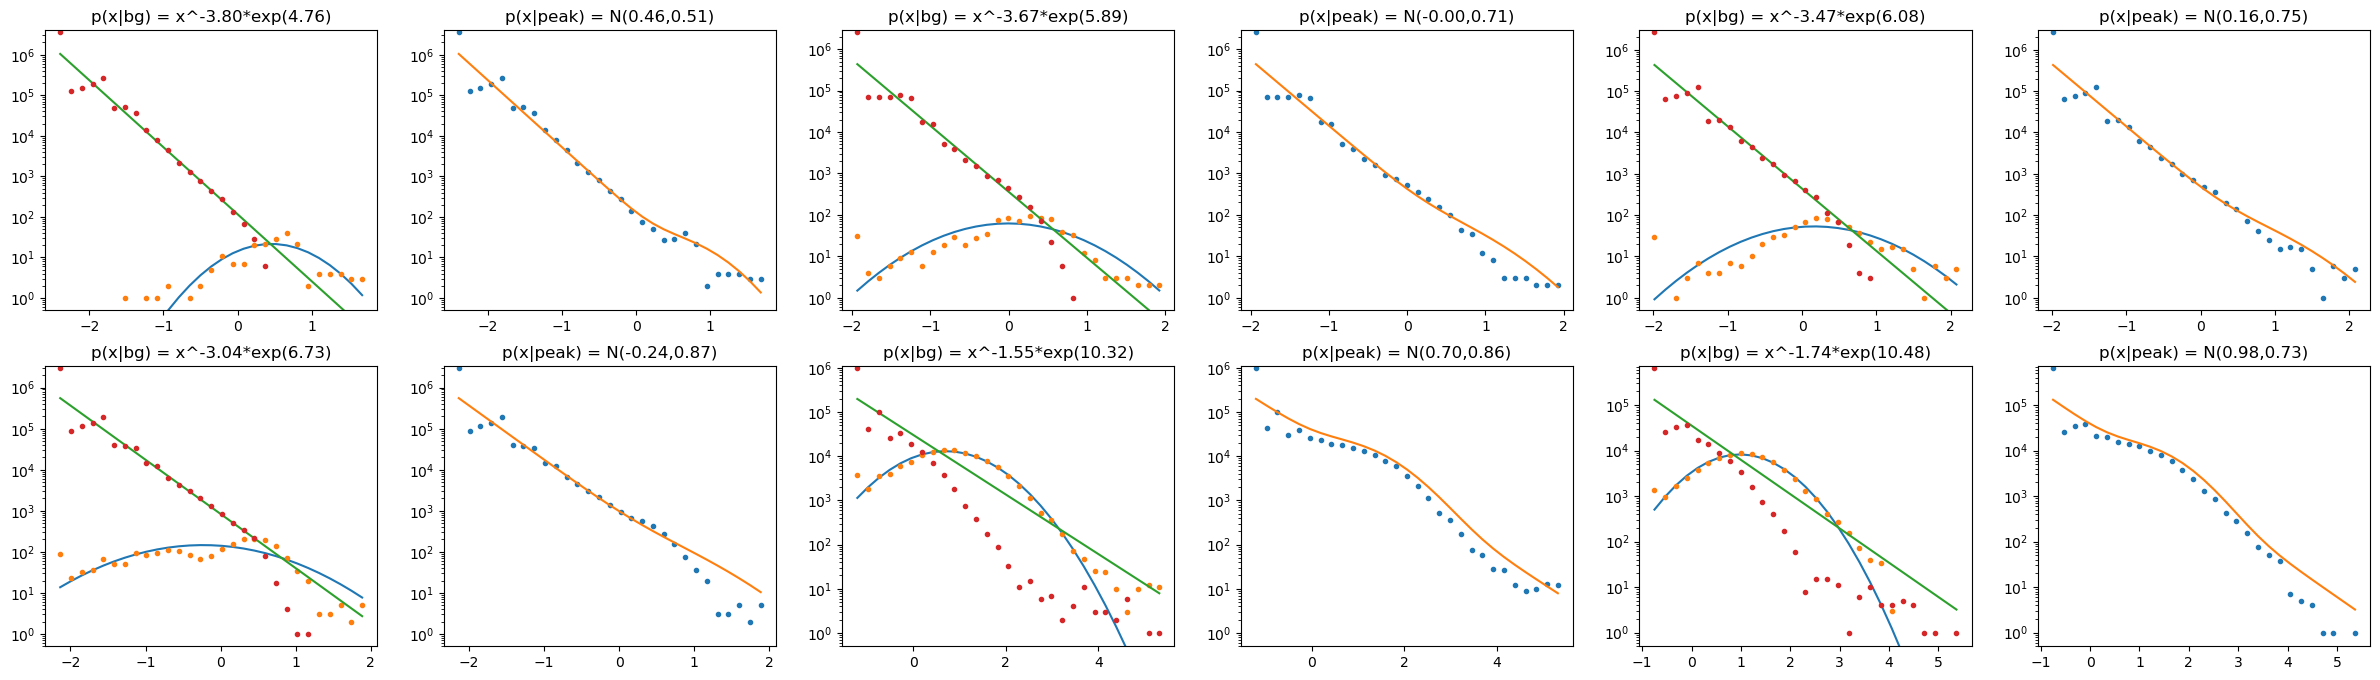

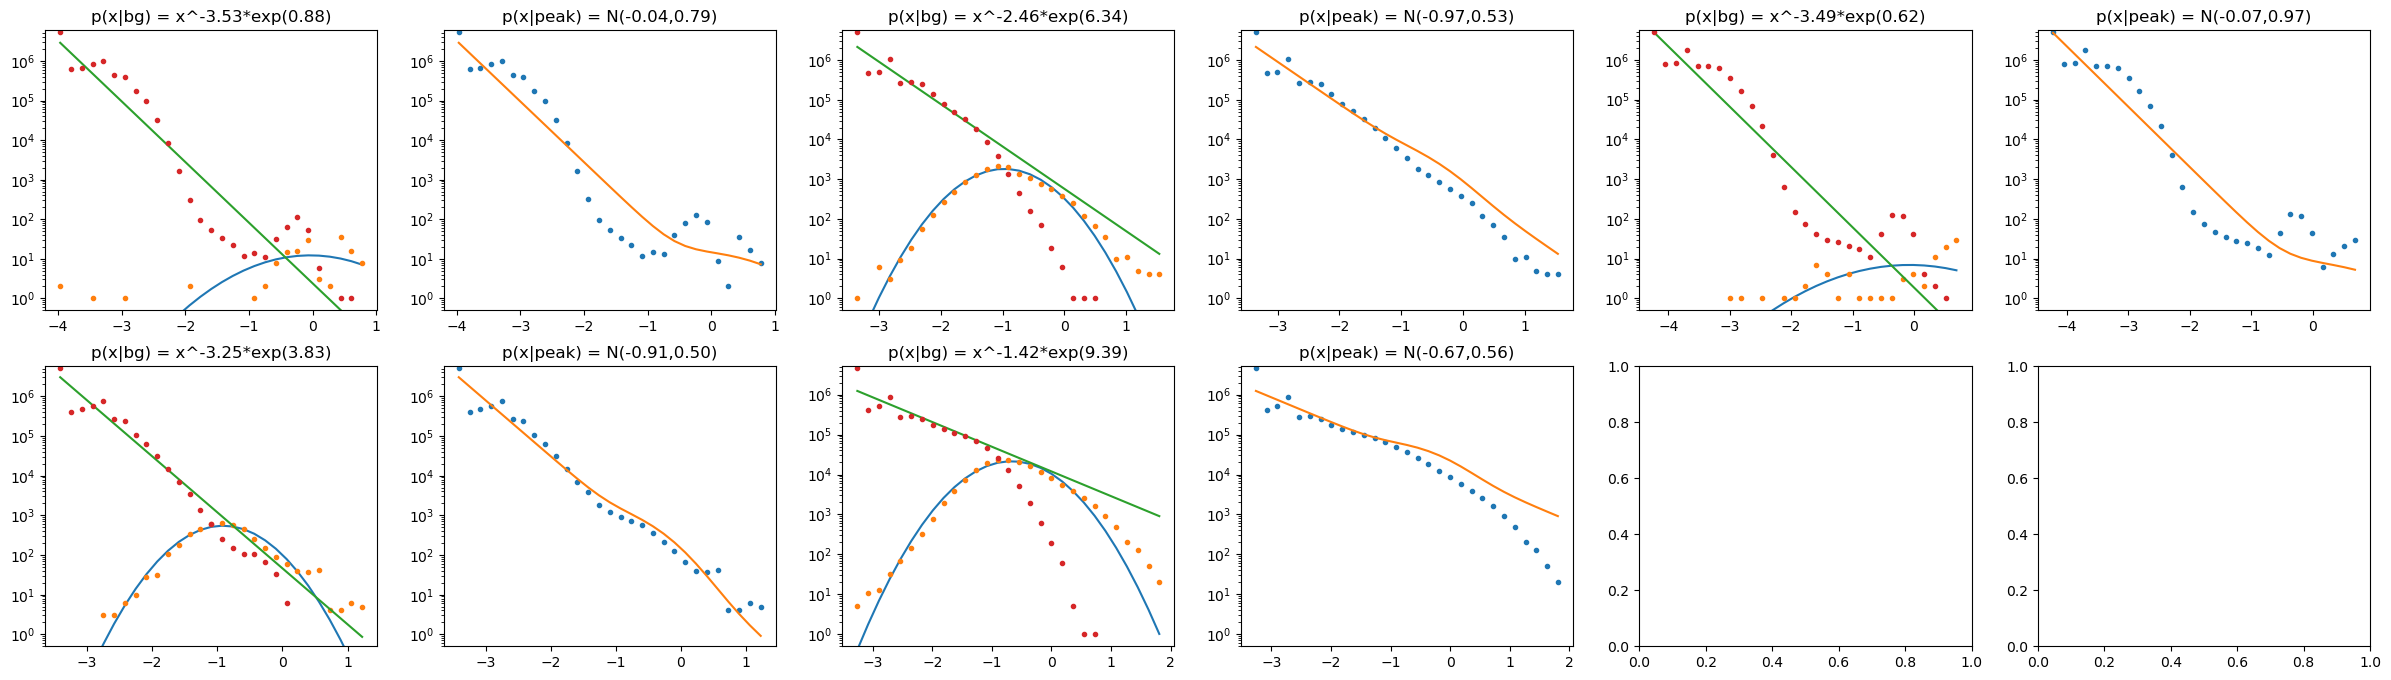

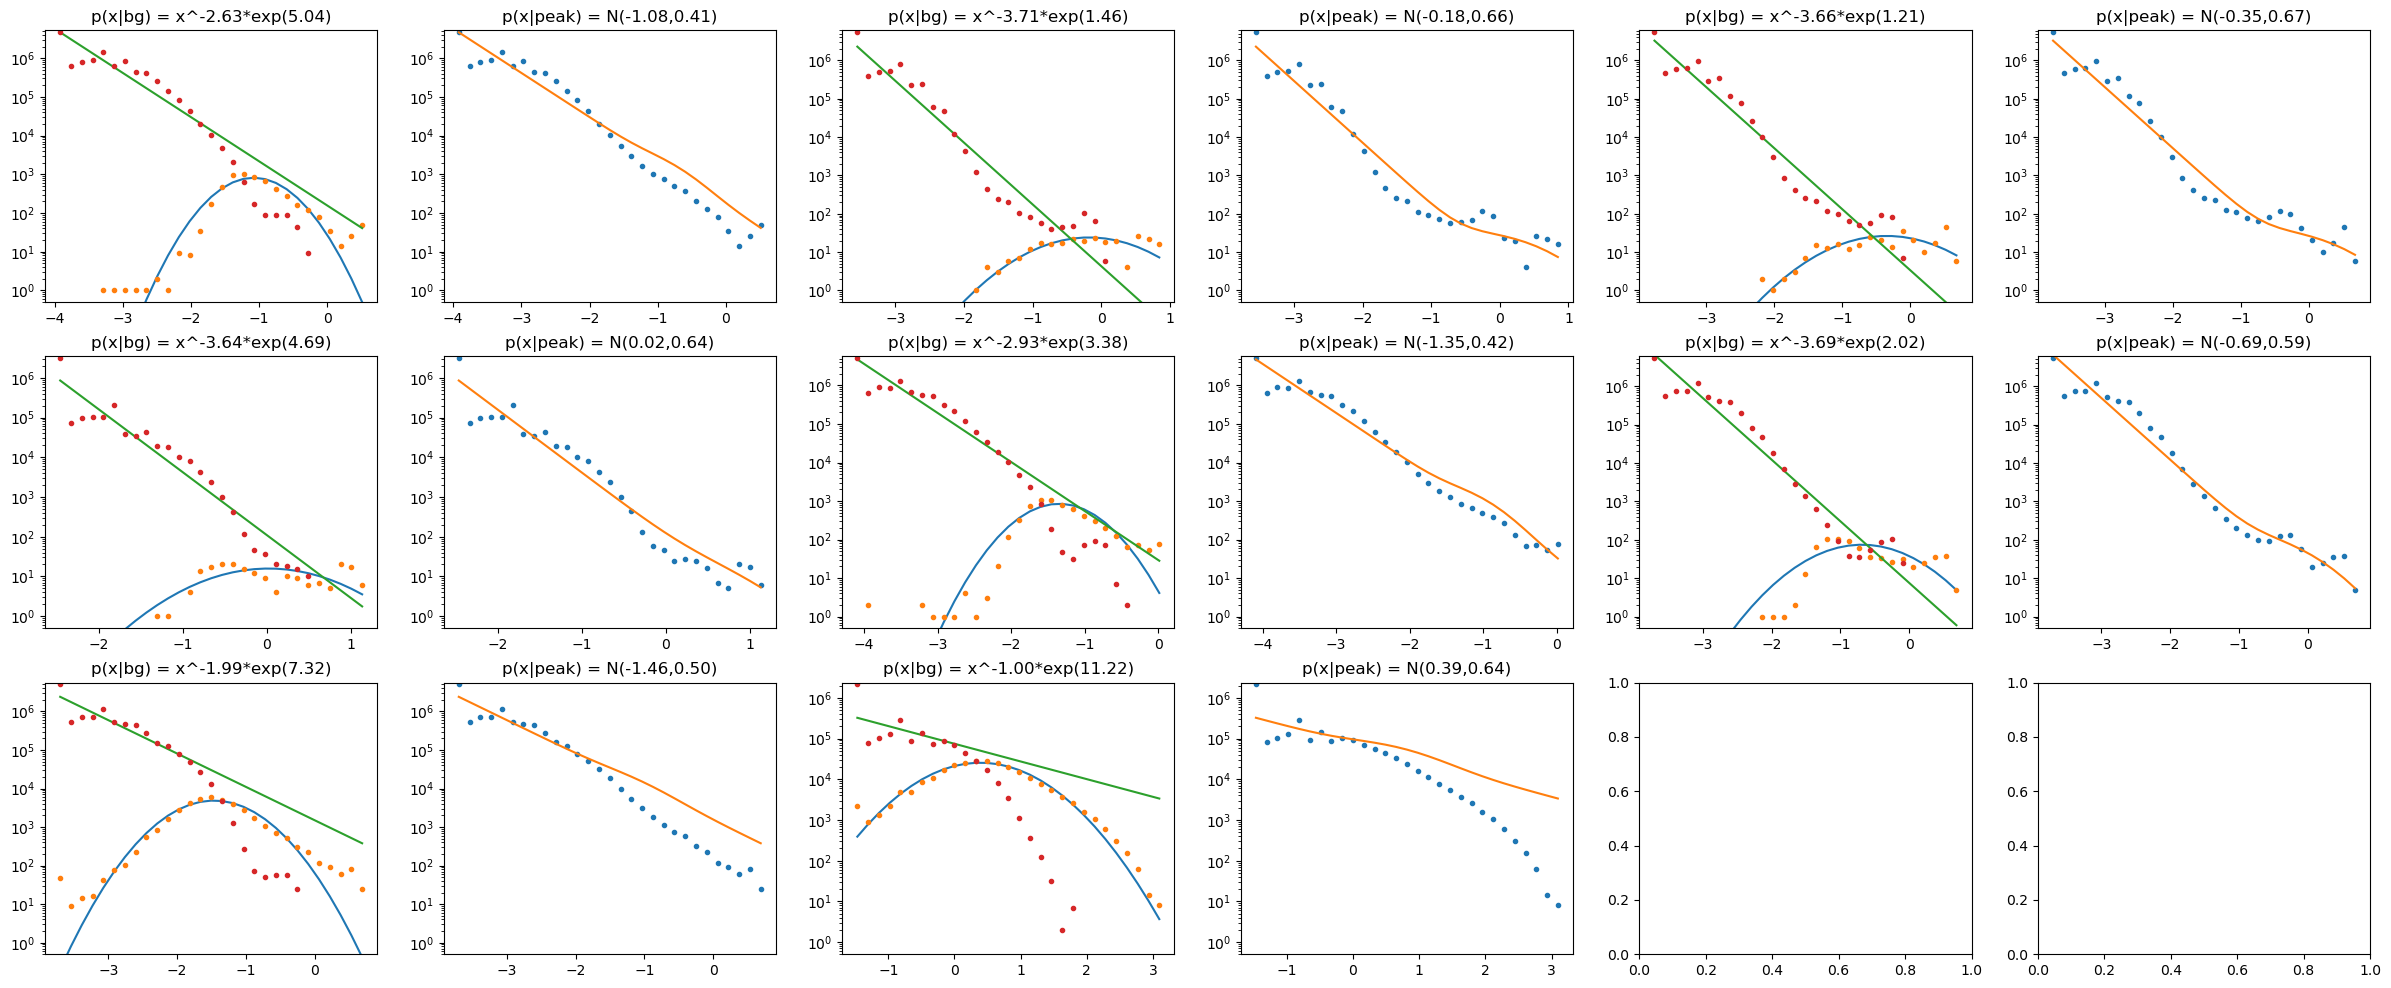

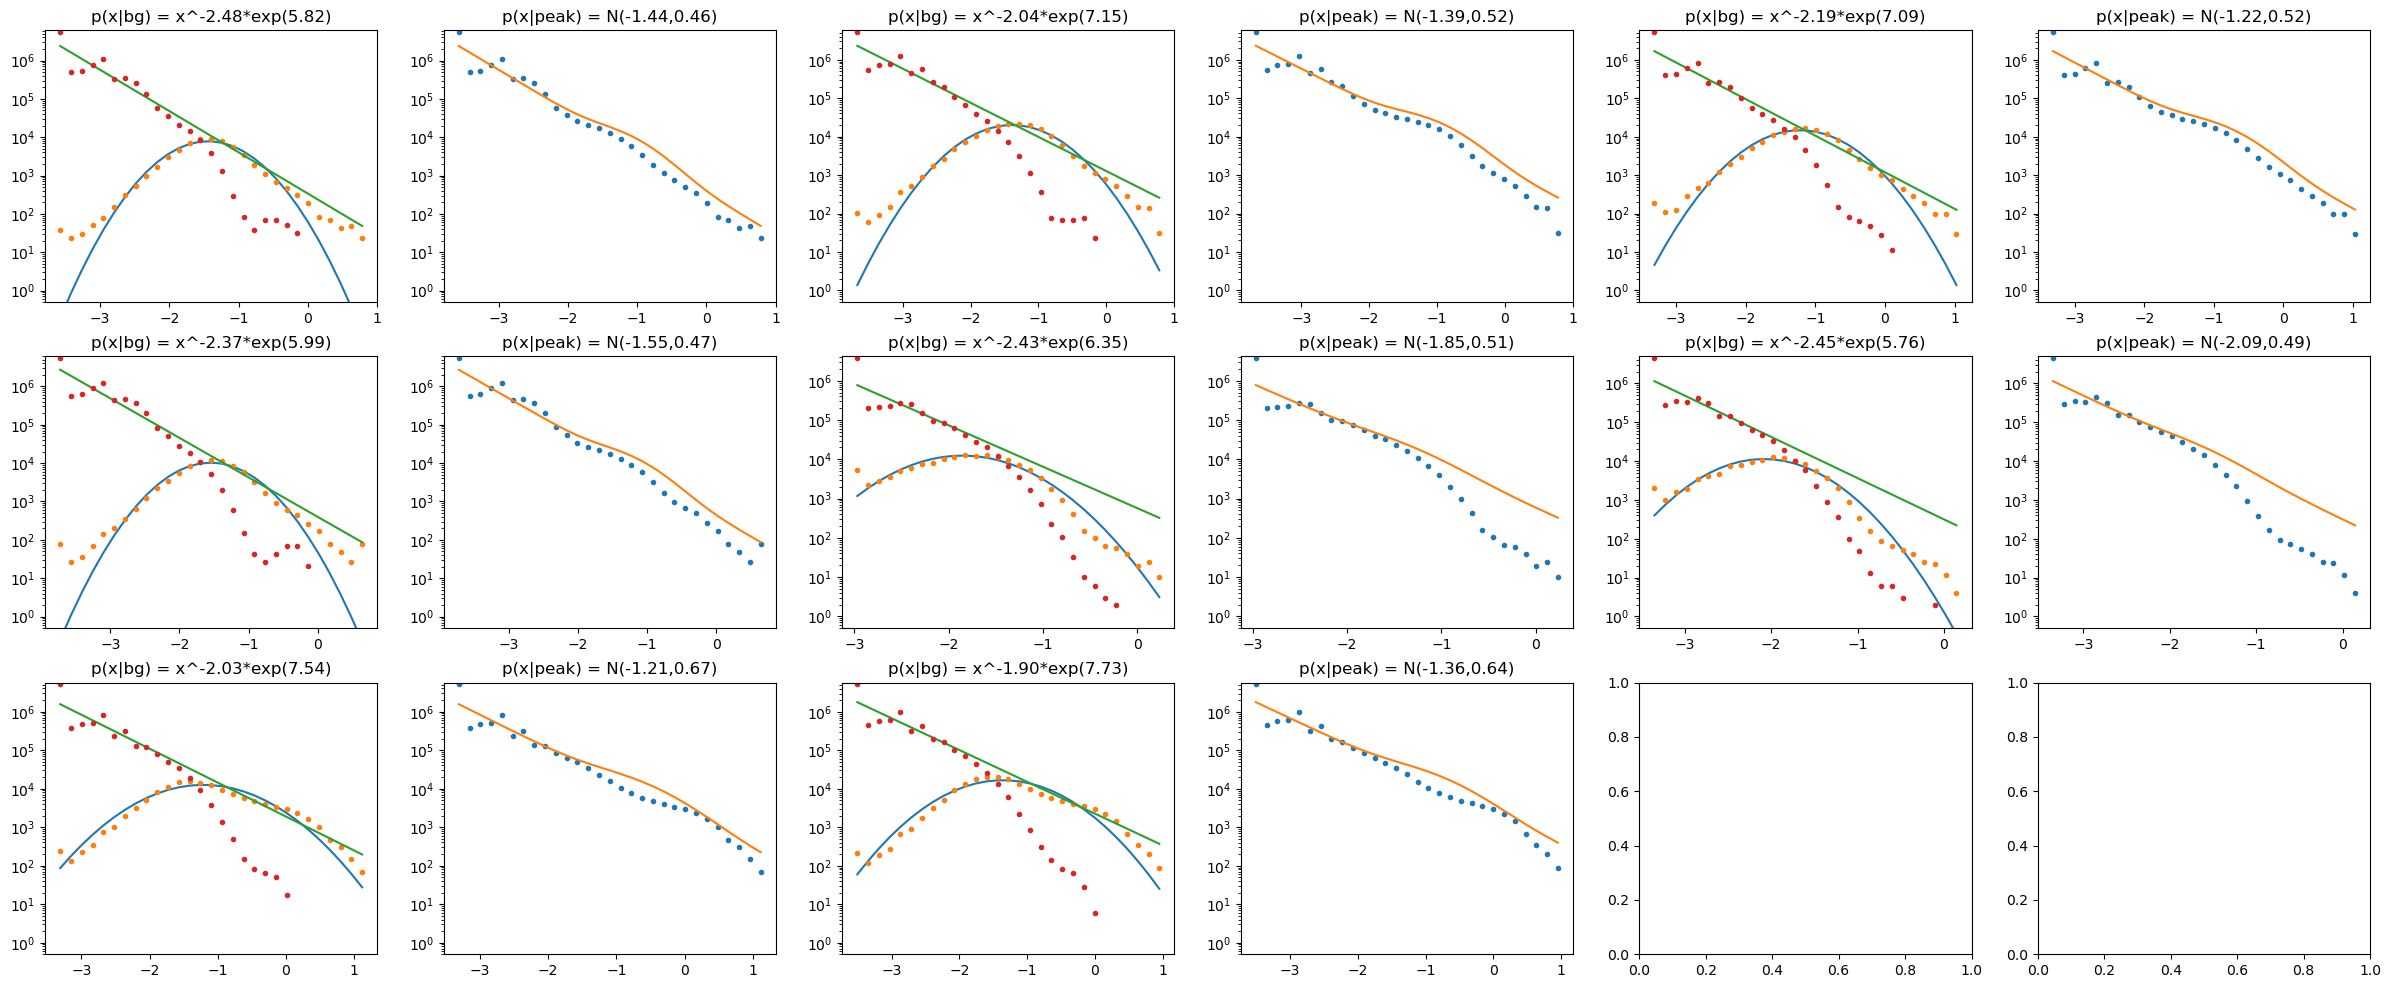

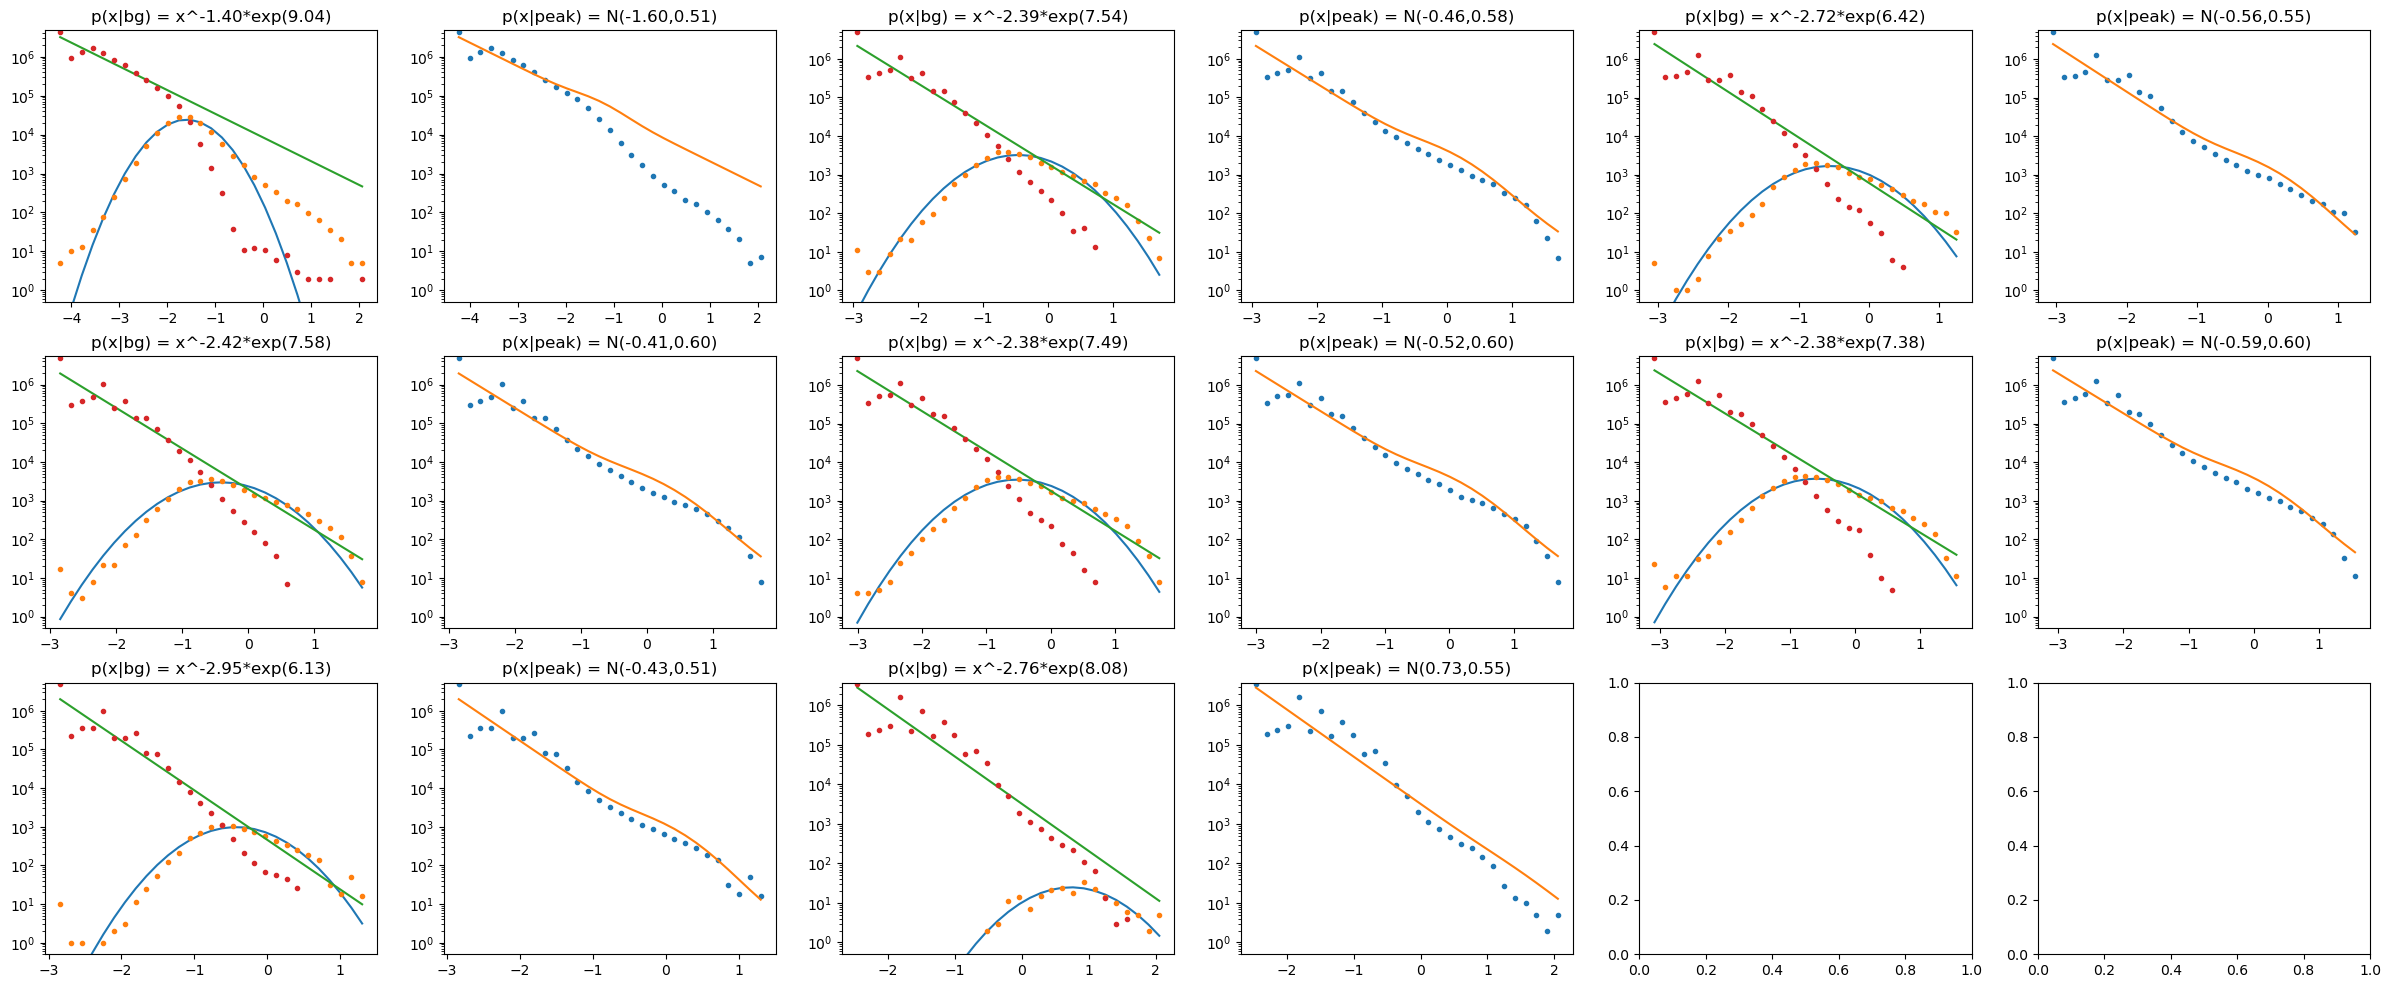

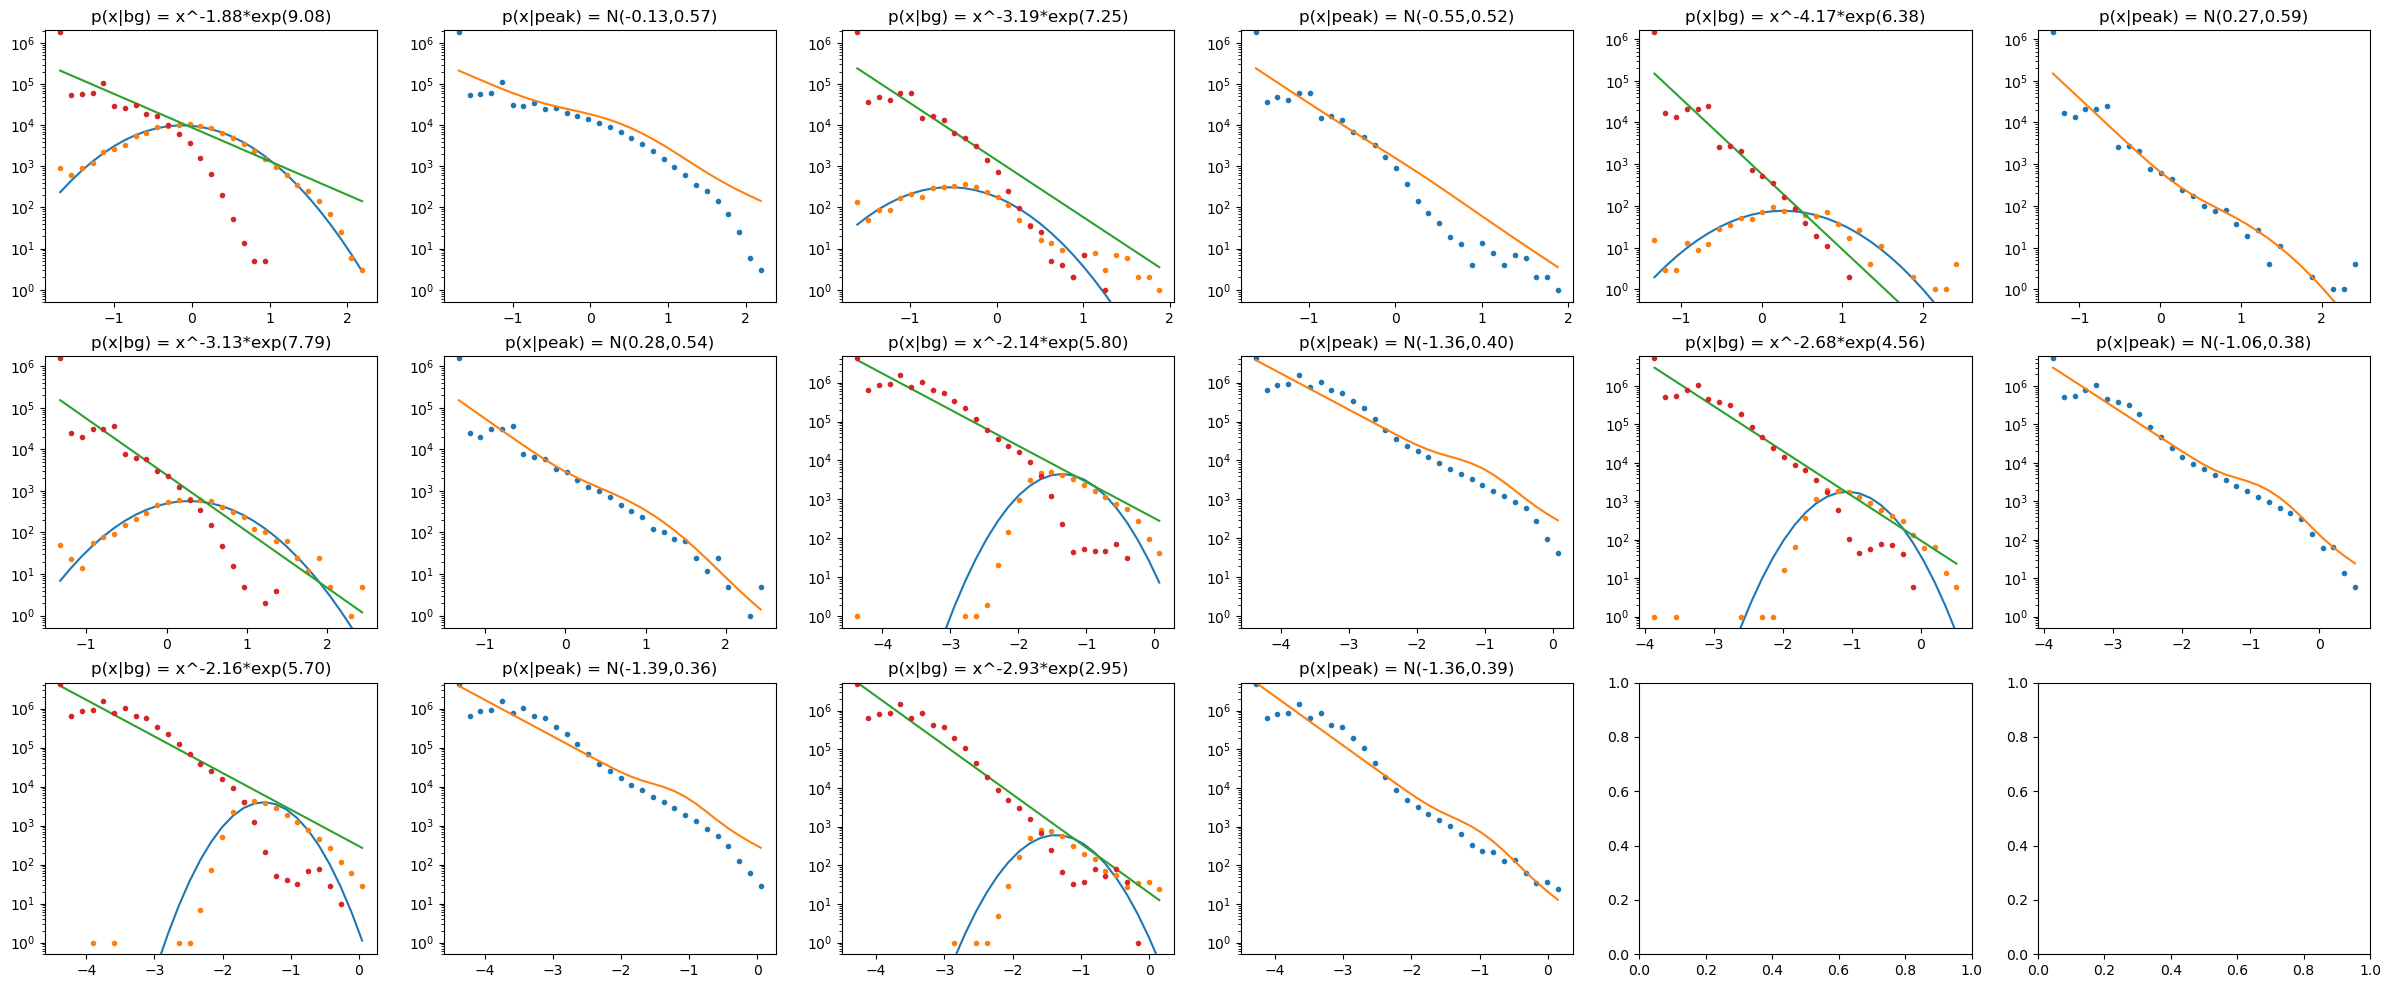

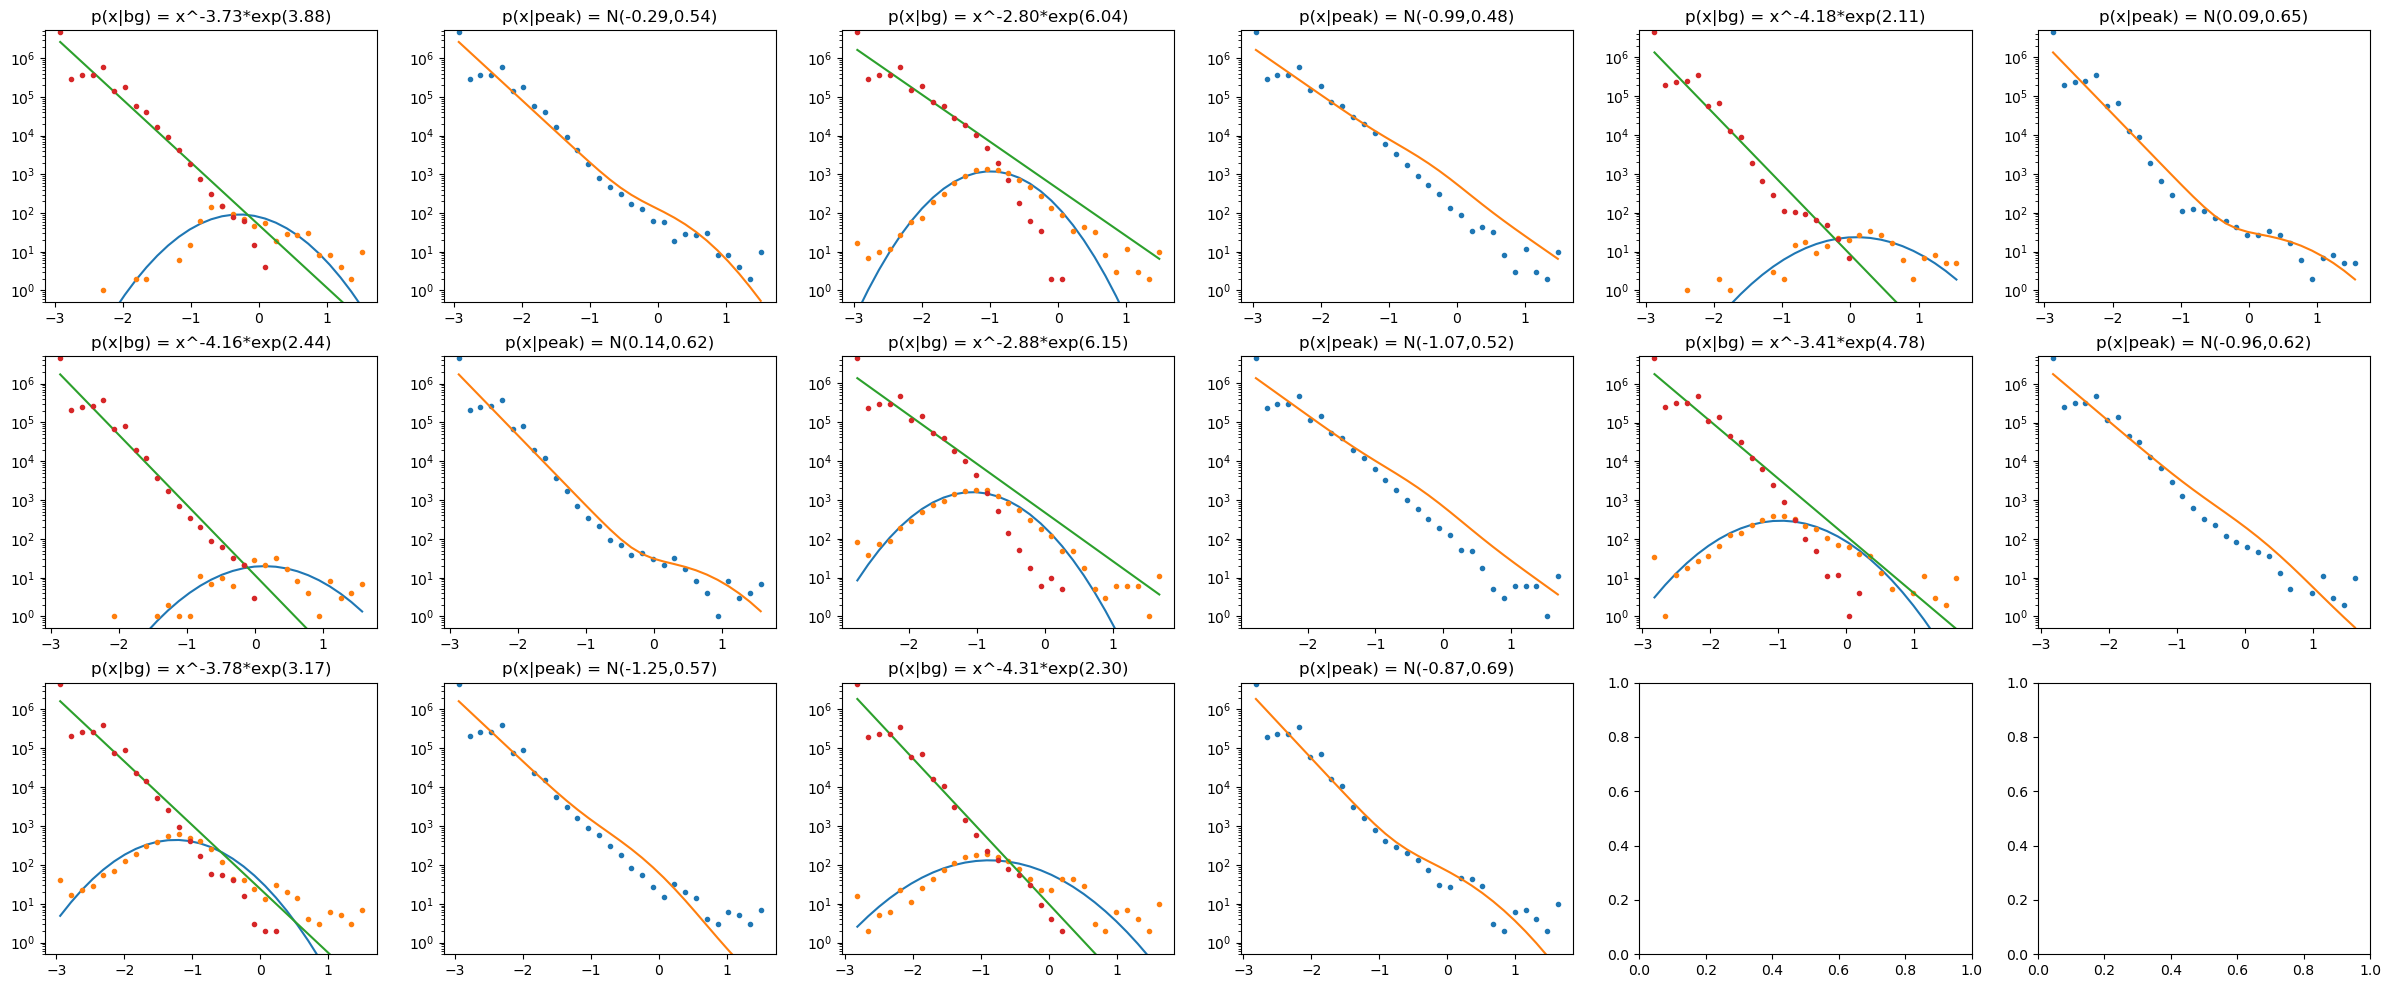

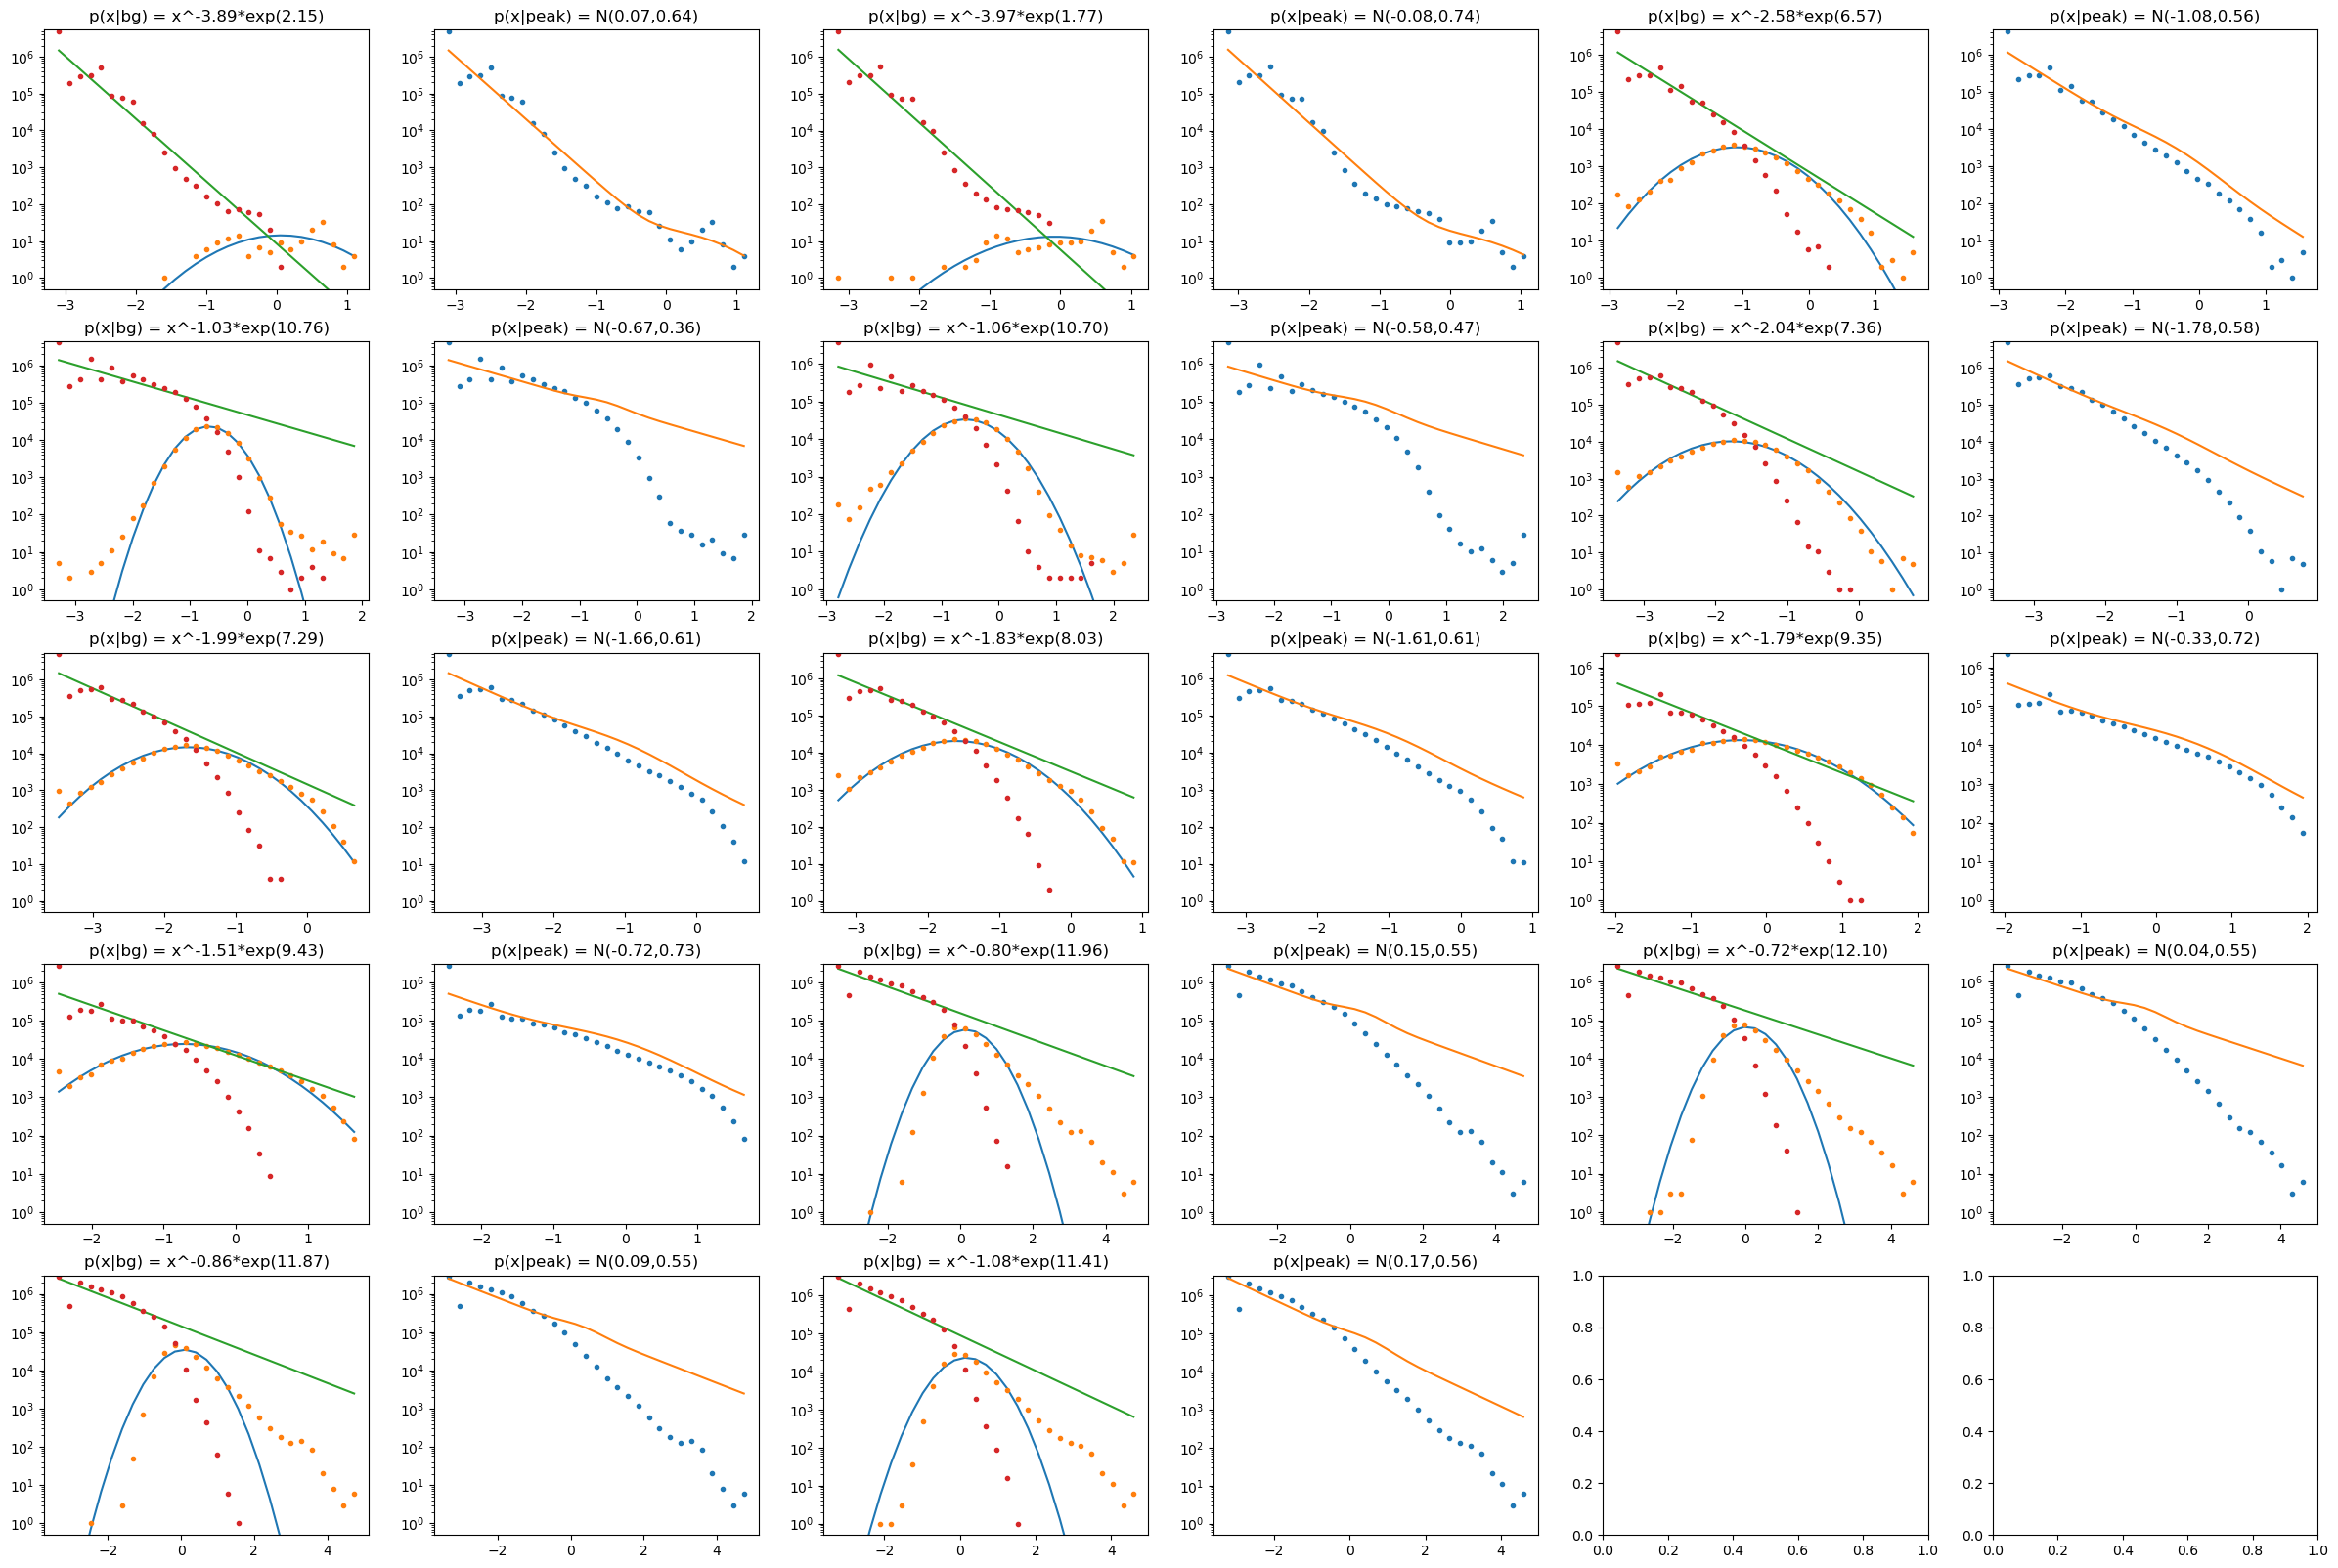

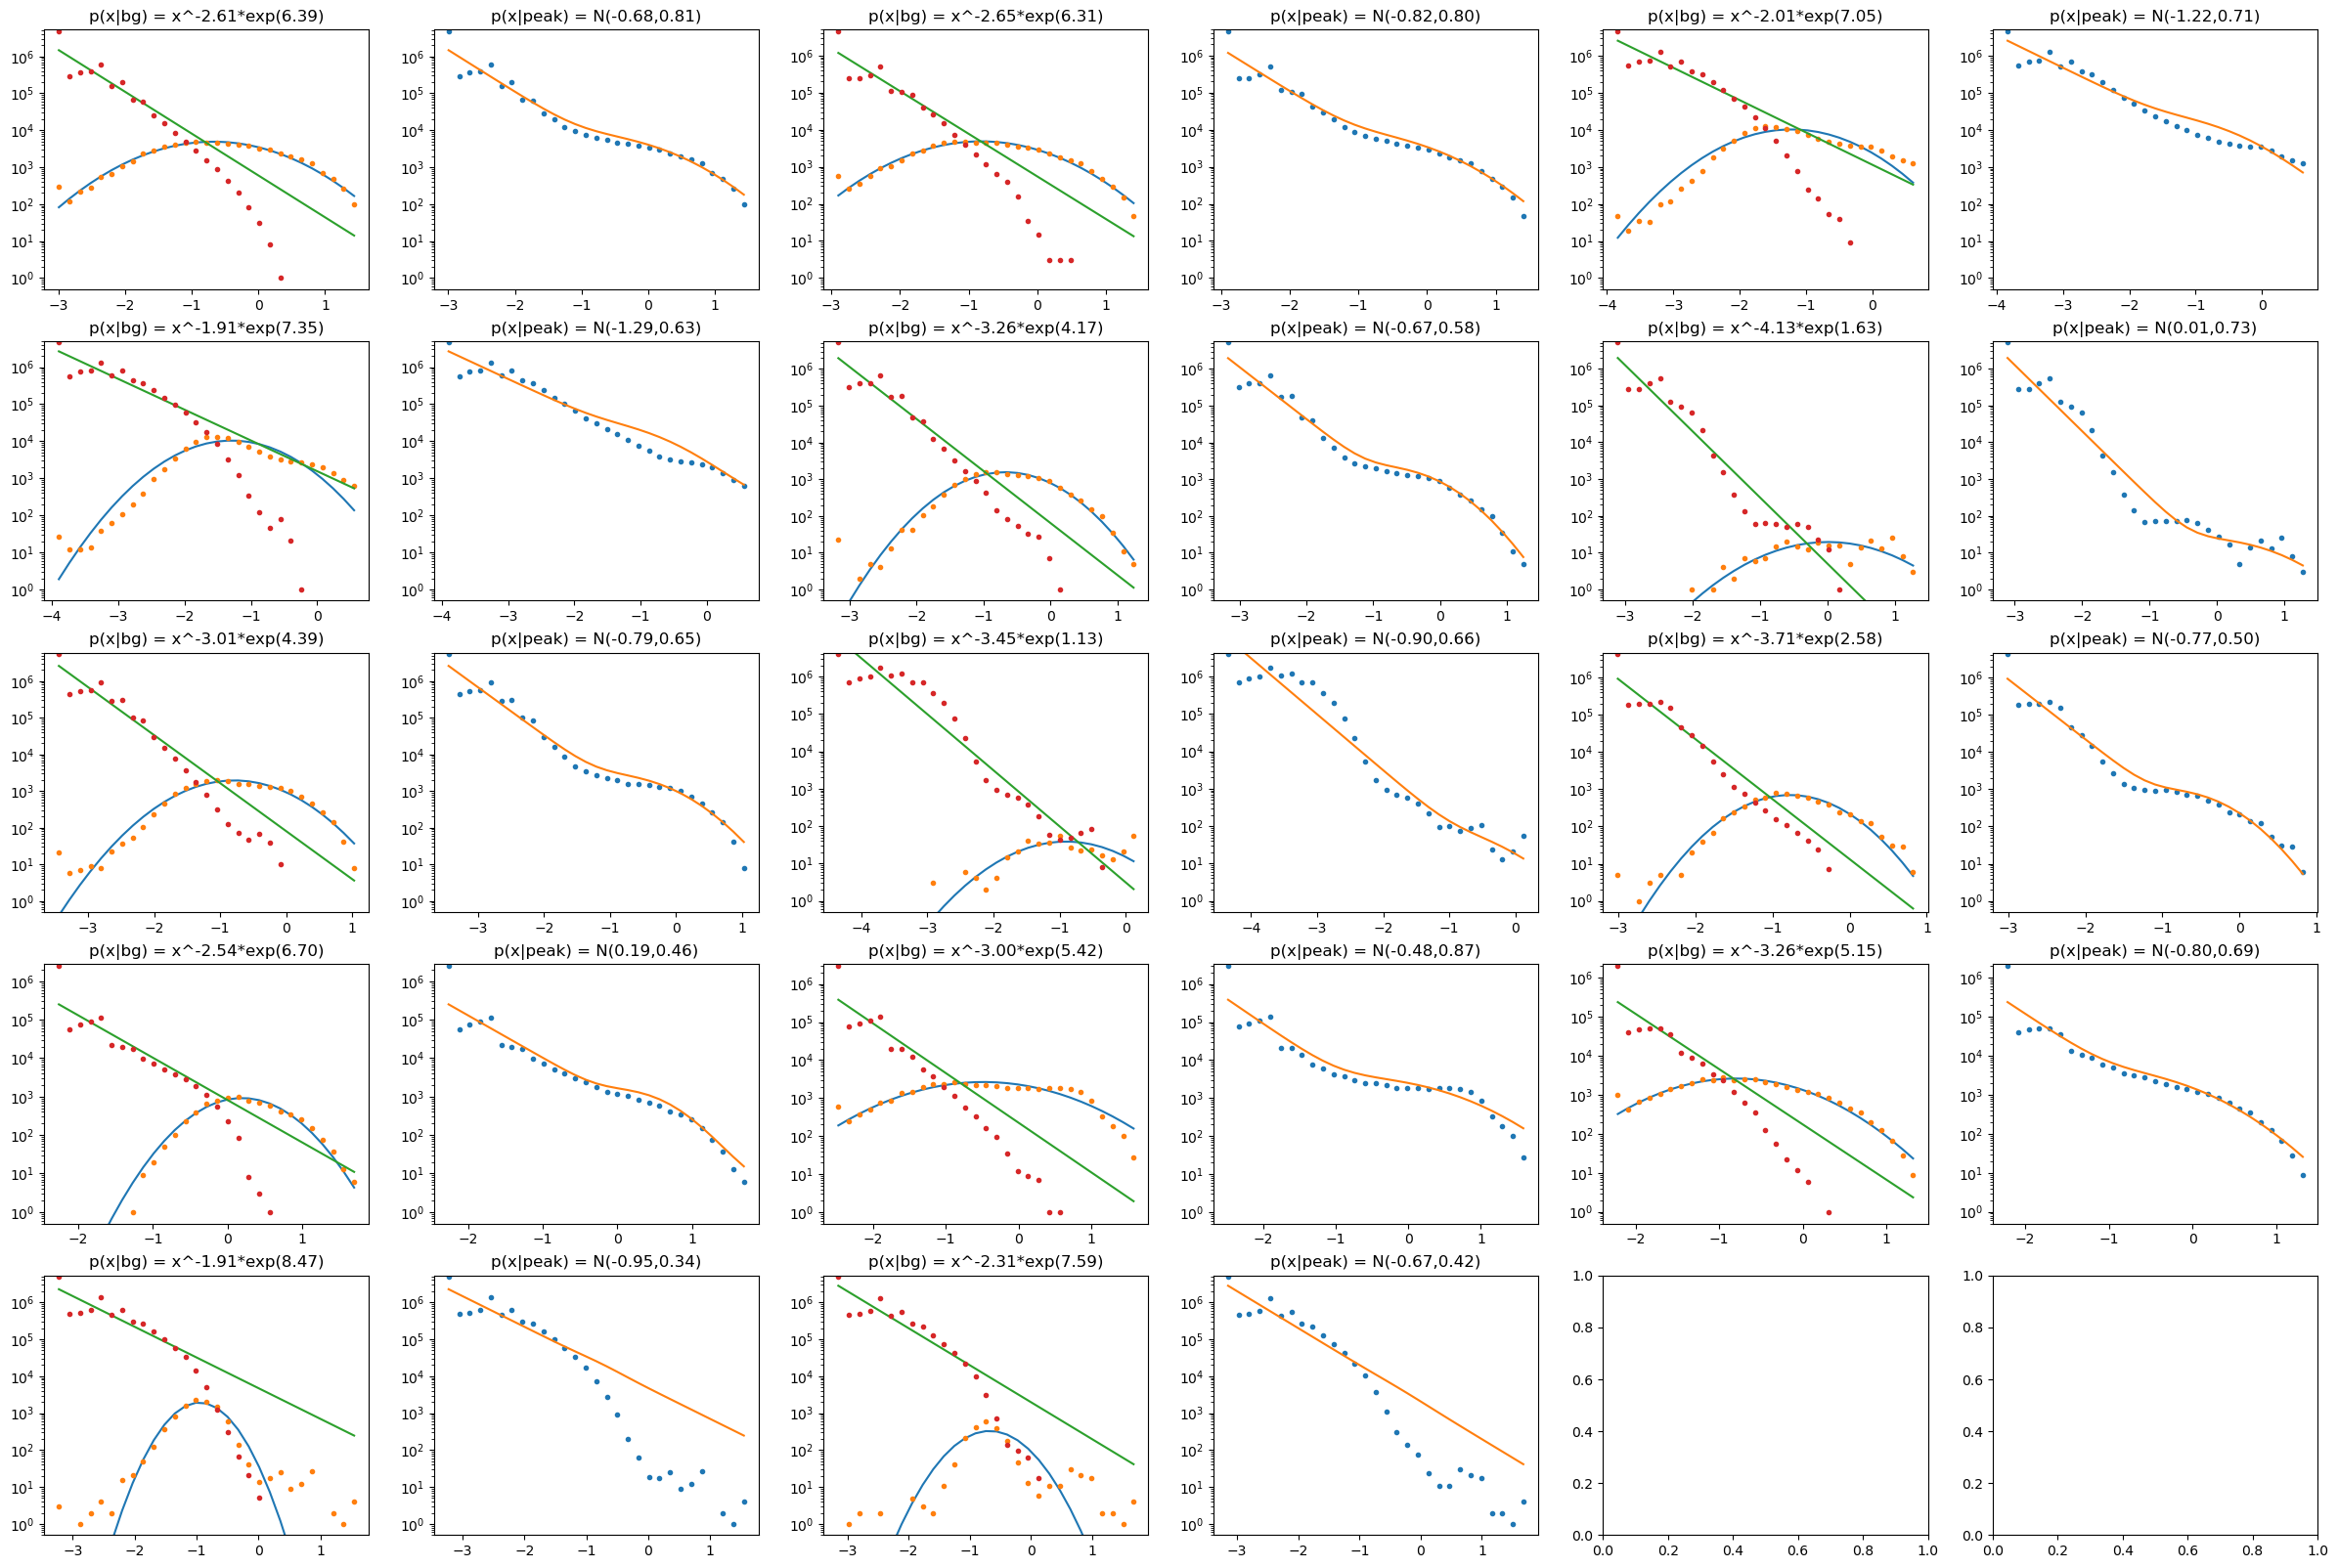

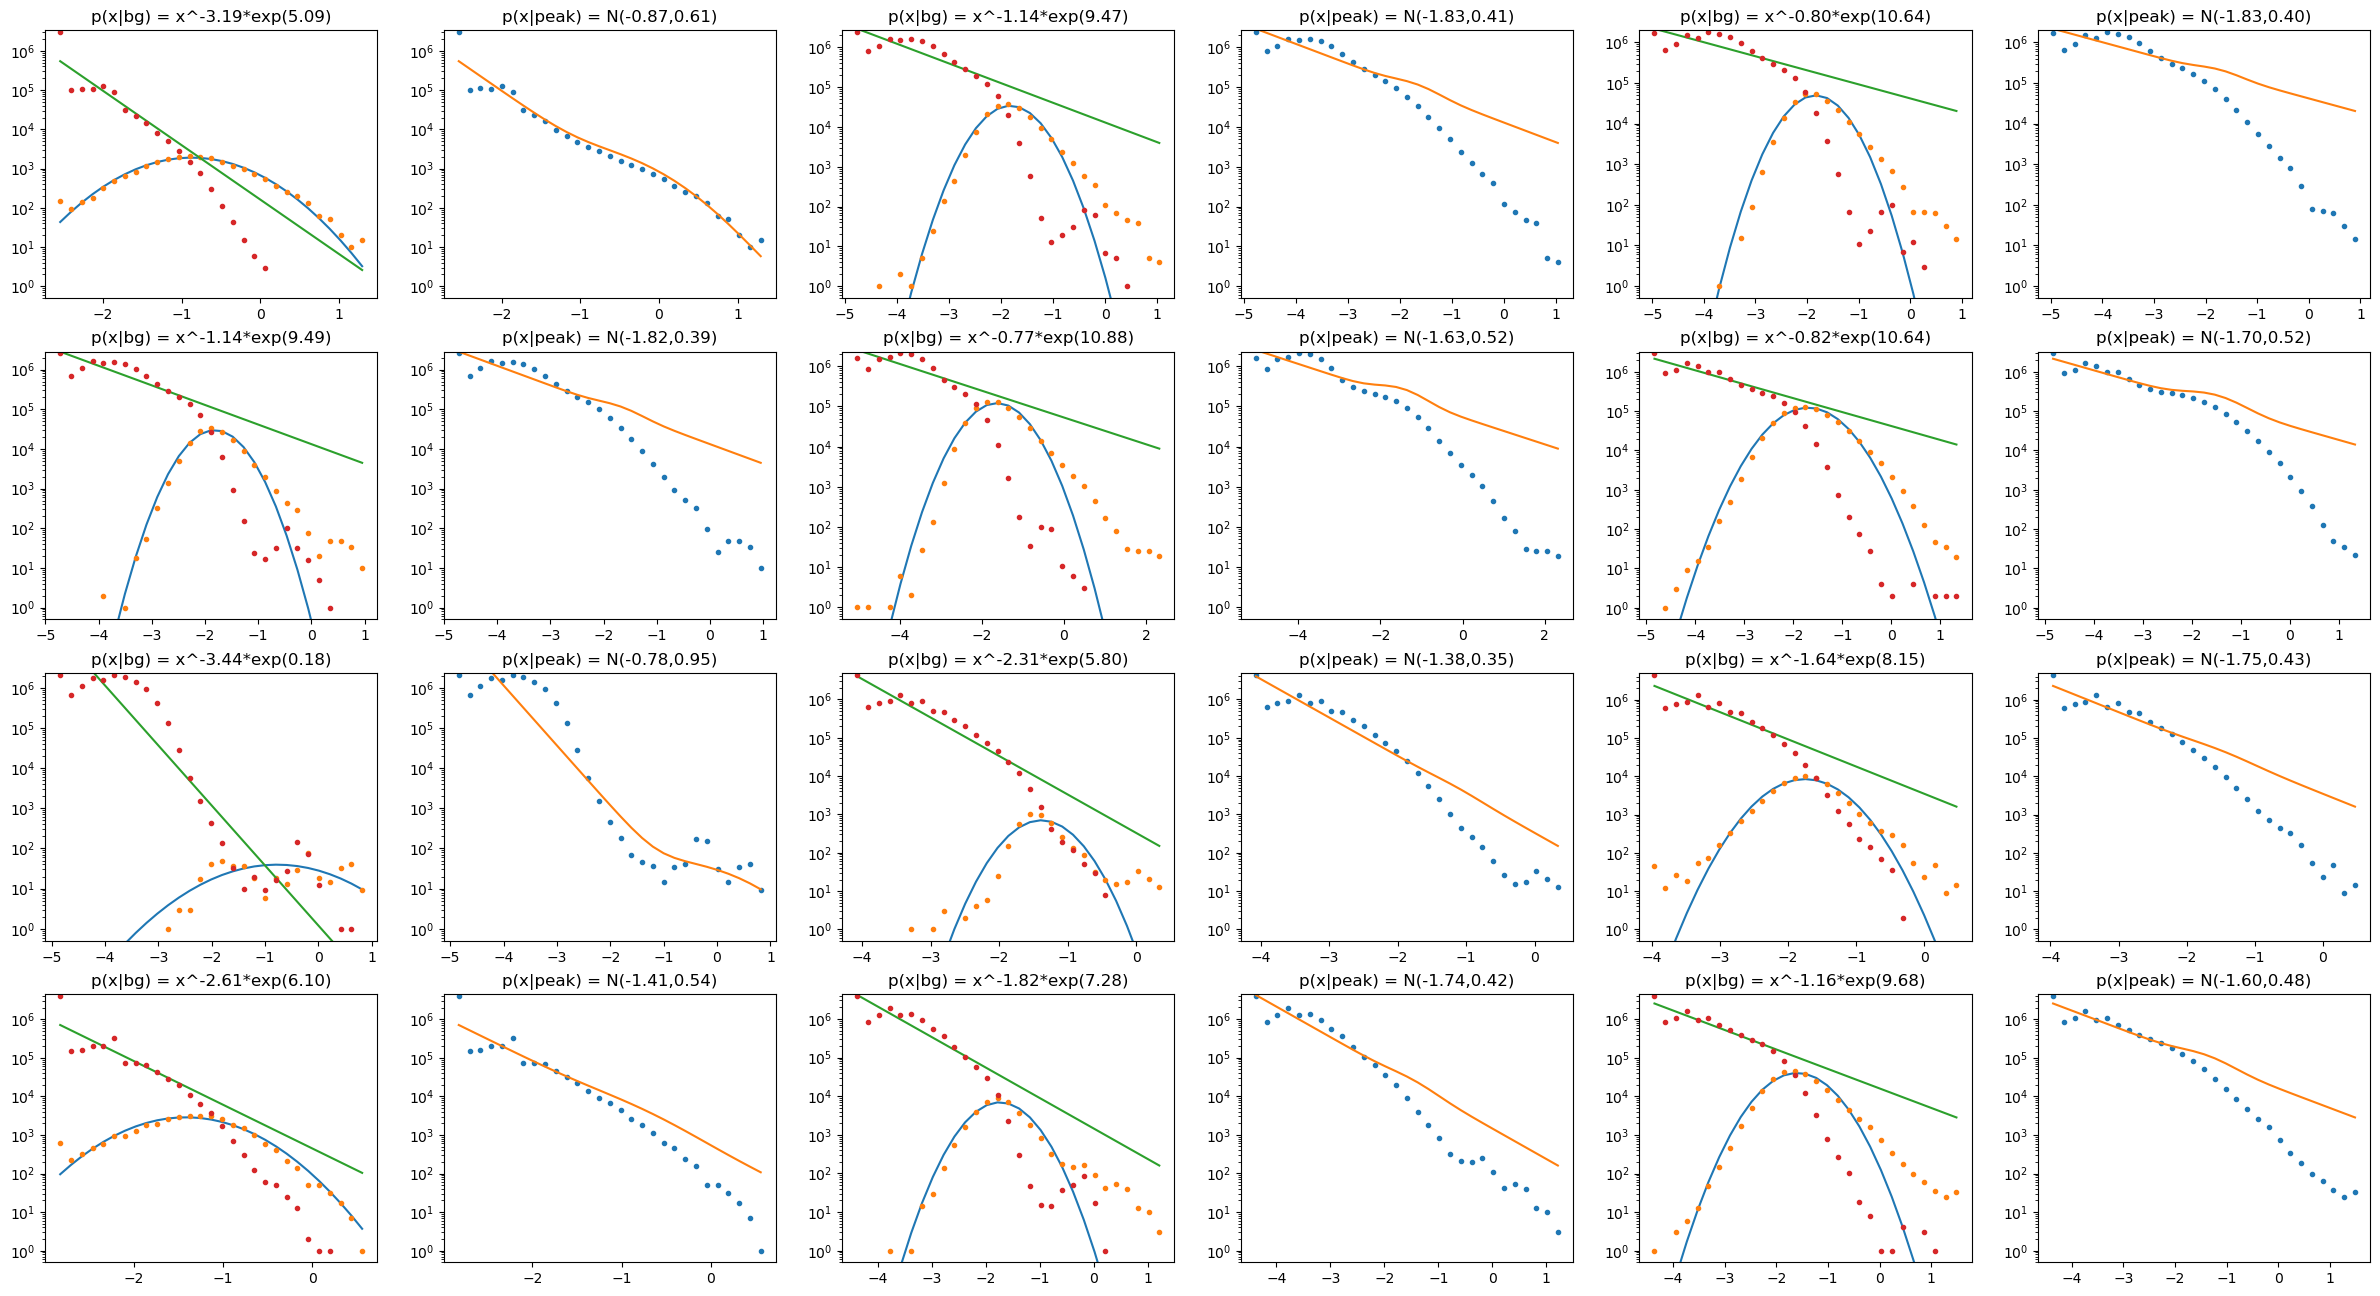

In [4]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
bin_size = 20
win_size_kb = 5
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"

for my_tf in TFs:
    print(my_tf)

    # get TF tensor
    infile = f'../results/{genome}/Chip_tensors/Window_pm{win_size_kb}kb_bin_size_{bin_size}/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        X = hf['chip_prom_pos_exp'][:]
        my_ids = hf['chip_prom_pos_exp'].attrs['exp_id'].split(',')
    N_prom, N_pos, N_exp = X.shape
    X = X.reshape([N_prom*N_pos,N_exp])
            
    # get peaks tensor
    infile = f'../results/mm10/Peak_tensors/Window_pm{win_size_kb}kb/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        Peaks = hf['peak_prom_pos_exp'][:]
    # bin peaks
    Peaks_binned = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)
    Peaks_binned = Peaks_binned.reshape([N_prom*N_pos,N_exp])

    # get cell types
    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    n_cols = 6
    n_rows = int(np.ceil(2*(N_exp)/n_cols))
    fig, axes = plt.subplots(n_rows,n_cols,figsize=(n_cols*5,n_rows*4))
    for i in range(N_exp):

        # data
        data = X[:,i]
        data = data[~np.isnan(data)]
        bins = np.linspace(np.log(data.min()),1.01*np.log(data.max()),30) 
        x = (bins[:-1]+bins[1:])/2
        dx = np.diff(x)[0]

        # peak data
        data_peak = X[Peaks_binned[:,i],i]
        data_peak = data_peak[~np.isnan(data_peak)]
        n_peak = len(data_peak)

        # back ground data
        data_bg = X[~Peaks_binned[:,i],i]
        data_bg = data_bg[~np.isnan(data_bg)]
        n_bg = len(data_bg)

        # empirical distributions
        h = np.histogram(np.log(data),bins=bins)[0]
        h_peak = np.histogram(np.log(data_peak),bins=bins)[0]
        h_bg = np.histogram(np.log(data_bg),bins=bins)[0]

        # fit a normal distribution on the peaks data
        mu = np.mean(np.log(data_peak))
        std = np.std(np.log(data_peak))
        y_peak = stats.norm.pdf(x, mu, std)

        # fit a power law on back ground data
        idx = (h_bg > 0) & ~np.isnan(h_bg) & (x <= mu)
        p = np.polyfit(x[idx],np.log(h[idx]),1)
        y_bg = np.exp(p[0]*x + p[1])

        # joined distribution
        rho = n_peak/(n_peak+n_bg)
        y = stats.norm.pdf(x, mu, std)*n_peak*dx + np.exp(p[0]*x + p[1])

        # plot
        ax = axes.flatten()[2*i]
        ax.plot(x,y_peak*n_peak*dx)
        ax.plot(x,h_peak,'.')
        ax.plot(x,y_bg)
        ax.plot(x,h_bg,'.')
        ax.set_yscale('log')
        ax.set_ylim([0.5,1.1*h.max()])
        ax.set_title(f'p(x|bg) = x^{p[0]:.2f}*exp({p[1]:.2f})')

        ax = axes.flatten()[2*i+1]

        ax.plot(x,h,'.')
        ax.plot(x,y)
        ax.set_yscale('log')
        ax.set_ylim([0.5,1.1*h.max()])
        ax.set_title(f'p(x|peak) = N({mu:.2f},{std:.2f})')
        

E2f1
0, 1, 2, 3, 4, 5, 
Mnt
0, 1, 2, 3, 4, 
Sox4
0, 1, 2, 3, 4, 5, 6, 7, 
Pou2af1
0, 1, 2, 3, 4, 5, 6, 7, 
Bach1
0, 1, 2, 3, 4, 5, 6, 7, 
E2f3
0, 1, 2, 3, 4, 5, 6, 7, 
Fosb
0, 1, 2, 3, 4, 5, 6, 7, 
Otx2
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
Pbx1
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
Pax7
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 


/tmp/ipykernel_48164/3007237198.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  [tf_u,df.tf_n] = np.unique(df.tf,return_inverse=True)


Text(0, 0.5, '$\\sigma$ bg')

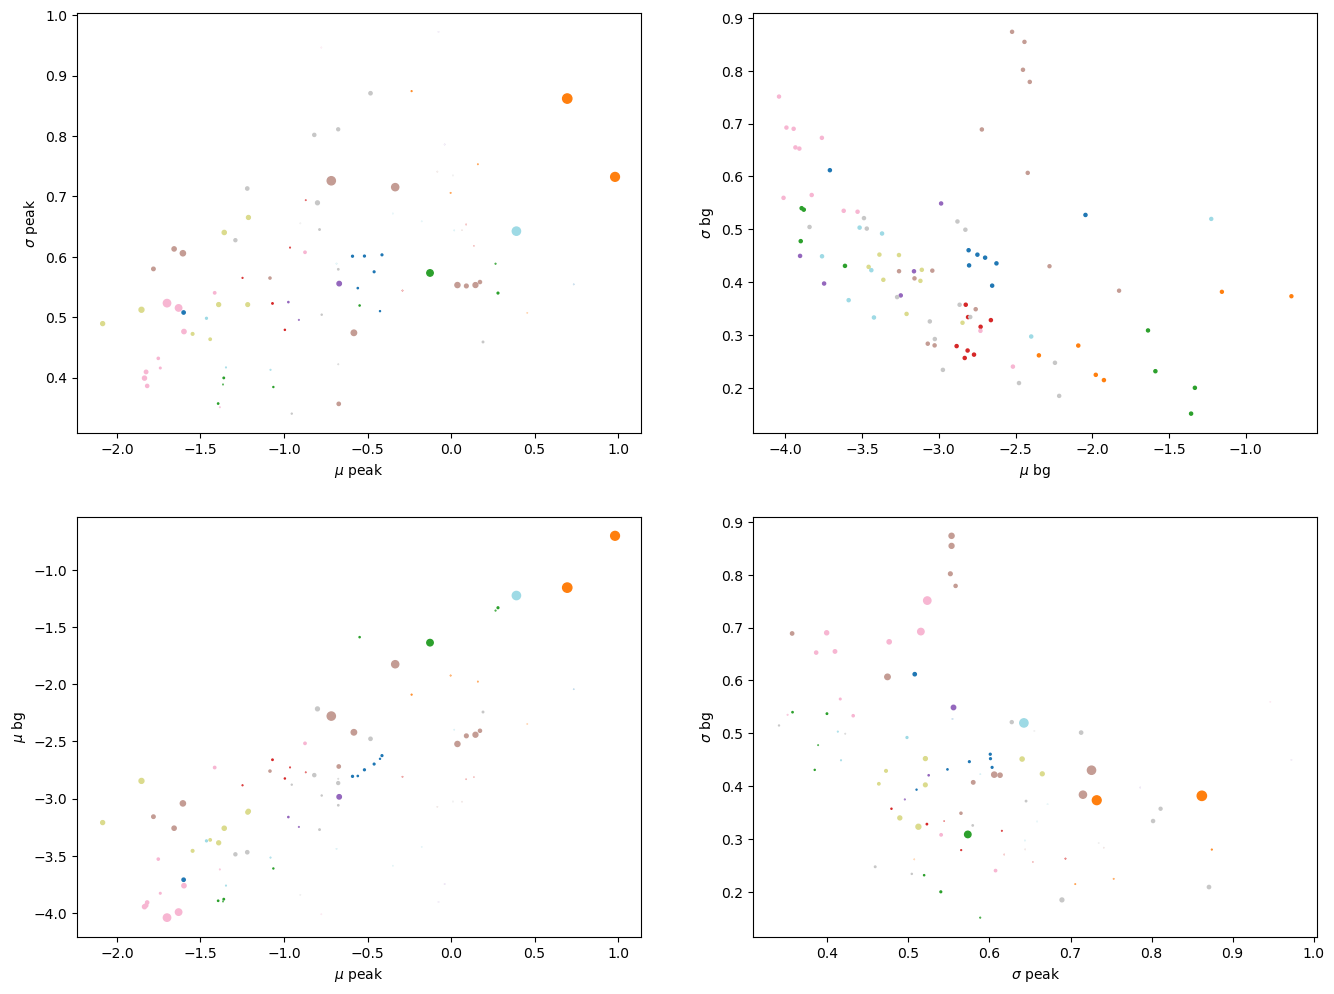

In [50]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
bin_size = 20
win_size_kb = 5
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"

mu_std_f_peak_bg_tf = []

mu_0 = 0

for my_tf in TFs:
    print(my_tf)

    # get TF tensor
    infile = f'../results/{genome}/Chip_tensors/Window_pm{win_size_kb}kb_bin_size_{bin_size}/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        X = hf['chip_prom_pos_exp'][:]
    N_prom, N_pos, N_exp = X.shape
    X = X.reshape([N_prom*N_pos,N_exp])
            
    # get peaks tensor
    infile = f'../results/mm10/Peak_tensors/Window_pm{win_size_kb}kb/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        Peaks = hf['peak_prom_pos_exp'][:]
    # bin peaks
    Peaks_binned = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)
    Peaks_binned = Peaks_binned.reshape([N_prom*N_pos,N_exp])

    for i in range(N_exp):
        print(i,end=', ')

        # data
        data = X[:,i]
        data = data[~np.isnan(data)]

        # peak data
        data_peak = X[Peaks_binned[:,i],i]
        data_peak = data_peak[~np.isnan(data_peak)]
        mu_peak = np.mean(np.log(data_peak))
        std_peak = np.std(np.log(data_peak))
        f_peak = len(data_peak)/len(data)

        # back ground data
        data_bg = X[~Peaks_binned[:,i],i]
        data_bg = data_bg[~np.isnan(data_bg)]
        
        
        mu_bg = np.mean(np.log(data_bg))
        std_bg = np.std(np.log(data_bg))
        f_bg = len(data_bg)/len(data)

        mu_std_f_peak_bg_tf.append([mu_peak,std_peak,f_peak,mu_bg,std_bg,f_bg,my_tf])
    print()


df = pd.DataFrame(mu_std_f_peak_bg_tf,columns=['mu_peak','std_peak','f_peak','mu_bg','std_bg','f_bg','tf'])
for c in df.columns[:-1]:
    df[c] = df[c].astype(float)
df.tf = df.tf.astype(str)

[tf_u,df.tf_n] = np.unique(df.tf,return_inverse=True)
N_tf = len(tf_u)

fig, axes = plt.subplots(2,2,figsize=(2*8,2*6))

ax = axes[0,0]
ax.scatter(df.mu_peak,df.std_peak,s=500*df.f_peak,c=df.tf_n,cmap='tab20')
ax.set_xlabel(r'$\mu$ peak')
ax.set_ylabel(r'$\sigma$ peak')

ax = axes[0,1]
ax.scatter(df.mu_bg,df.std_bg,s=5*df.f_bg,c=df.tf_n,cmap='tab20')
ax.set_xlabel(r'$\mu$ bg')
ax.set_ylabel(r'$\sigma$ bg')

ax = axes[1,0]
ax.scatter(df.mu_peak,df.mu_bg,s=500*df.f_peak,c=df.tf_n,cmap='tab20')
ax.set_xlabel(r'$\mu$ peak')
ax.set_ylabel(r'$\mu$ bg')

ax = axes[1,1]
ax.scatter(df.std_peak,df.std_bg,s=500*df.f_peak,c=df.tf_n,cmap='tab20')
ax.set_xlabel(r'$\sigma$ peak')
ax.set_ylabel(r'$\sigma$ bg')



/tmp/ipykernel_48164/3024417995.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  [tf_u,df.tf_n] = np.unique(df.tf,return_inverse=True)


Text(0, 0.5, '$\\sigma$ bg')

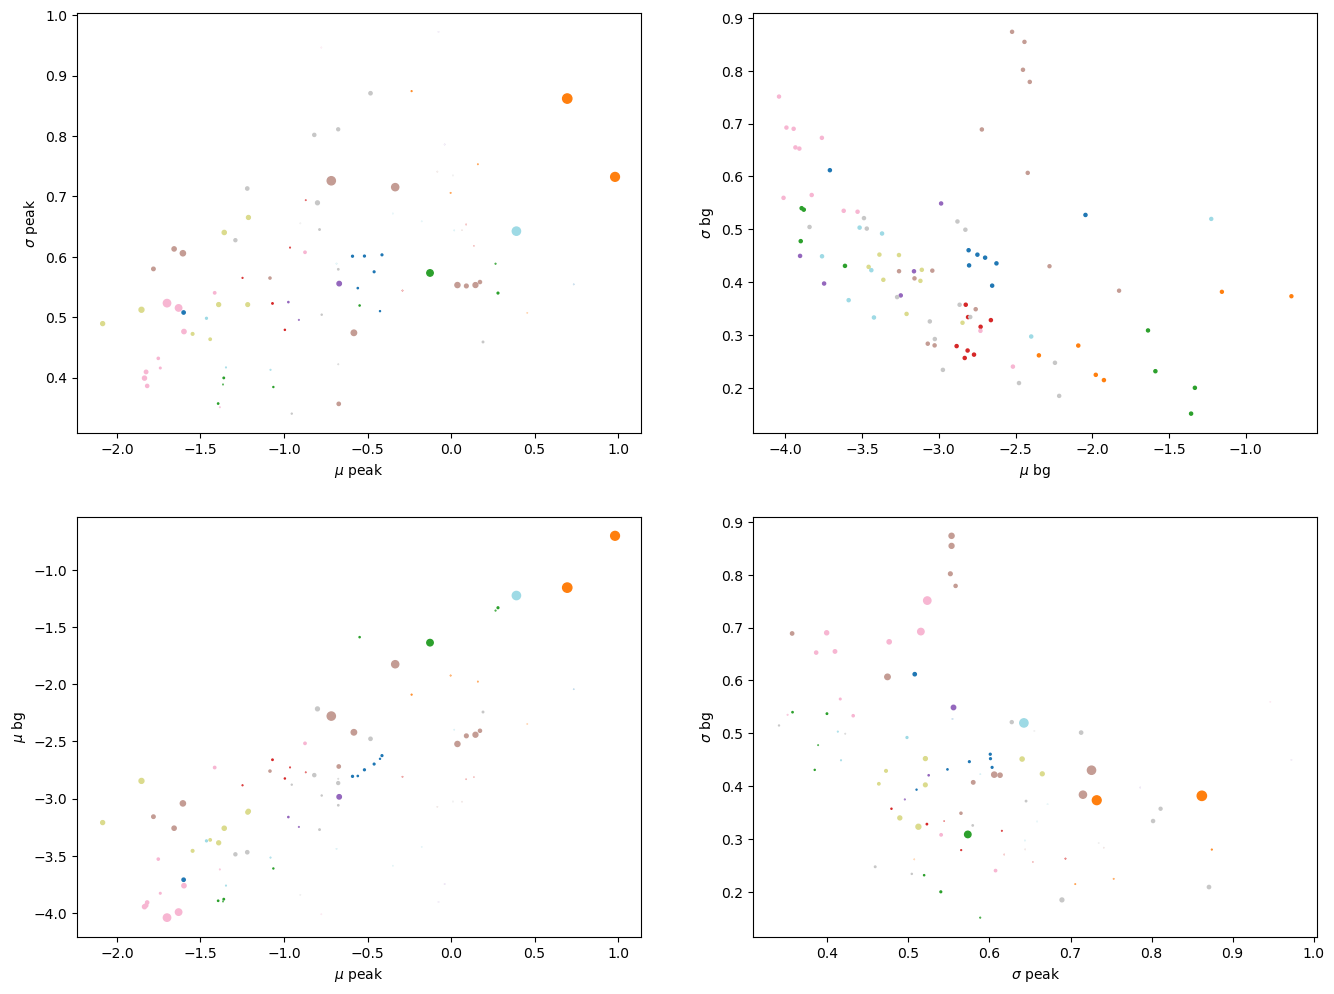

In [46]:
df = pd.DataFrame(mu_std_f_peak_bg_tf,columns=['mu_peak','std_peak','f_peak','mu_bg','std_bg','f_bg','tf'])
for c in df.columns[:-1]:
    df[c] = df[c].astype(float)
df.tf = df.tf.astype(str)

[tf_u,df.tf_n] = np.unique(df.tf,return_inverse=True)
N_tf = len(tf_u)

fig, axes = plt.subplots(2,2,figsize=(2*8,2*6))

ax = axes[0,0]
ax.scatter(df.mu_peak,df.std_peak,s=500*df.f_peak,c=df.tf_n,cmap='tab20')
ax.set_xlabel(r'$\mu$ peak')
ax.set_ylabel(r'$\sigma$ peak')

ax = axes[0,1]
ax.scatter(df.mu_bg,df.std_bg,s=5*df.f_bg,c=df.tf_n,cmap='tab20')
ax.set_xlabel(r'$\mu$ bg')
ax.set_ylabel(r'$\sigma$ bg')

ax = axes[1,0]
ax.scatter(df.mu_peak,df.mu_bg,s=500*df.f_peak,c=df.tf_n,cmap='tab20')
ax.set_xlabel(r'$\mu$ peak')
ax.set_ylabel(r'$\mu$ bg')

ax = axes[1,1]
ax.scatter(df.std_peak,df.std_bg,s=500*df.f_peak,c=df.tf_n,cmap='tab20')
ax.set_xlabel(r'$\sigma$ peak')
ax.set_ylabel(r'$\sigma$ bg')

# Normalization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import h5py
# import pycircstat
from collections import namedtuple
from scipy import stats
from scipy.cluster import hierarchy

E2f1
0
1
2
3
4
5


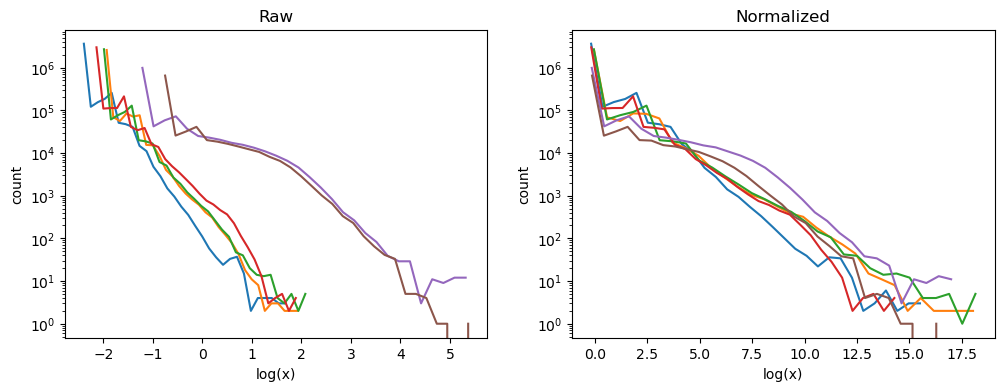

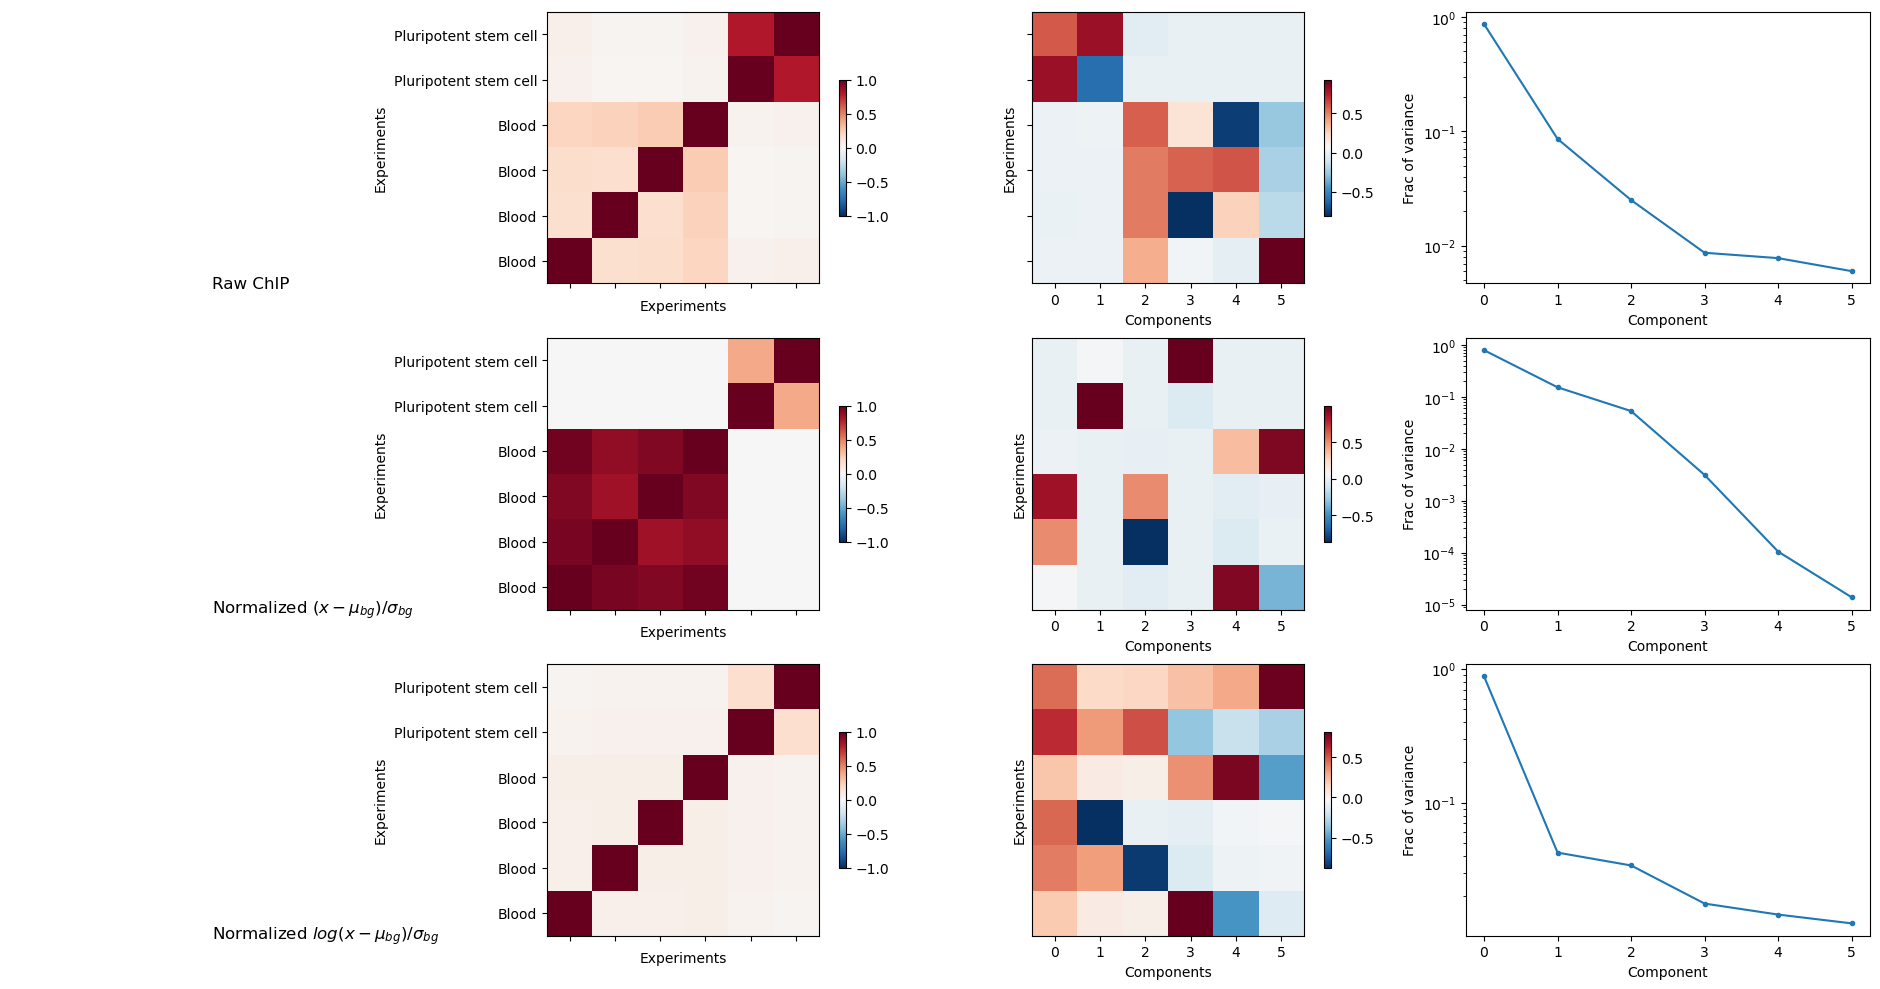

In [136]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
bin_size = 20
win_size_kb = 5
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"

for my_tf in TFs:
    print(my_tf)

    # get TF tensor
    infile = f'../results/{genome}/Chip_tensors/Window_pm{win_size_kb}kb_bin_size_{bin_size}/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        X = hf['chip_prom_pos_exp'][:]
        my_ids = hf['chip_prom_pos_exp'].attrs['exp_id'].split(',')
    N_prom, N_pos, N_exp = X.shape
    X = X.reshape([N_prom*N_pos,N_exp])
            
    # get peaks tensor
    infile = f'../results/mm10/Peak_tensors/Window_pm{win_size_kb}kb/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        Peaks = hf['peak_prom_pos_exp'][:]
    # bin peaks and reshape
    Peaks_binned = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)
    Peaks_binned = Peaks_binned.reshape([N_prom*N_pos,N_exp])

    # get cell types
    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    # initialize histograms
    N_bin = 30
    h_raw = np.zeros([N_bin,N_exp])
    x_raw = np.zeros([N_bin,N_exp])
    h_norm = np.zeros([N_bin,N_exp])
    x_norm = np.zeros([N_bin,N_exp])

    X_norm = np.zeros_like(X)
    X_norm[:] = np.nan

    for i in range(N_exp):
        print(i)

        # get non-nan data 
        idx_data = ~np.isnan(X[:,i])
        data = X[idx_data,i]
        
        # get distribution
        bins = np.linspace(np.log(data.min()),1.01*np.log(data.max()),N_bin+1)
        x_raw[:,i] = (bins[:-1]+bins[1:])/2
        h_raw[:,i] = np.histogram(np.log(data),bins=bins)[0]

        # get background mean and std only in non-peak and non-nan regions
        data_bg = X[~Peaks_binned[:,i],i]
        data_bg = np.log( data_bg[~np.isnan(data_bg)] )
        mu = np.mean(data_bg)
        std = np.std(data_bg)

        # normalize
        data_norm = np.exp( (np.log(data)-mu)/std )

        # get distribution
        bins = np.linspace(np.log(data_norm.min()),1.01*np.log(data_norm.max()),N_bin+1)
        x_norm[:,i] = (bins[:-1]+bins[1:])/2
        h_norm[:,i] = np.histogram(np.log(data_norm),bins=bins)[0]

        # get normalized data
        X_norm[idx_data,i] = data_norm


    # plot distributions
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    ax = axes.flatten()[0]
    ax.plot(x_raw,h_raw)
    ax.set_yscale('log')
    ax.set_title('Raw')
    ax.set_xlabel('log(x)')
    ax.set_ylabel('count')

    ax = axes.flatten()[1]
    ax.plot(x_norm,h_norm)
    ax.set_yscale('log')
    ax.set_title('Normalized')
    ax.set_xlabel('log(x)')
    ax.set_ylabel('count')



    fig, axes = plt.subplots(3,4,figsize=(4*6,2*6))
    ax = axes[0,0]
    ax.set_axis_off()
    ax.text(0,0.5,'Raw ChIP',fontsize=12,ha='left',va='center')
    ax = axes[1,0]
    ax.set_axis_off()
    ax.text(0,0.5,r'Normalized $(x-\mu_{bg})/\sigma_{bg}$',fontsize=12,ha='left',va='center')
    ax = axes[2,0]
    ax.set_axis_off()
    ax.text(0,0.5,r'Normalized $log (x-\mu_{bg})/\sigma_{bg}$',fontsize=12,ha='left',va='center')

    # replace nans with 0s in raw data
    X[np.isnan(X)] = 0

    # compute pearson corr.
    rho = np.corrcoef(X.T)
    # SVD
    U,S,Vh = np.linalg.svd(X,full_matrices=False)
    # change sign such that sum(U,0) > 0
    sign = np.sign(U.sum(axis=0,keepdims=True))
    U = sign*U
    Vh = sign.T*Vh


    # Get pcs, loadings and explained variance
    #X_svd = U @ np.diag(S) @ Vh
    Loadings = np.square(Vh)
    explained_var = np.square(S)
    explained_var /= sum(explained_var)

    # plot corr matrix
    ax = axes[0,1]
    pos = ax.imshow(rho, cmap='RdBu_r', interpolation=None,vmin=-1,vmax=1,origin='lower')
    fig.colorbar(pos, ax=ax, shrink=0.5,location='right')
    ax.set_xticklabels([])
    ax.set_yticks(range(len(celltype_idx)),my_celltype[celltype_idx])
    ax.set_xlabel('Experiments')
    ax.set_ylabel('Experiments')

    # plot experiment loadings
    ax = axes[0,2]
    pos = ax.imshow(Vh.T, cmap='RdBu_r', interpolation=None,origin='lower')
    fig.colorbar(pos, ax=ax,shrink=0.5, location='right')
    ax.set_yticklabels([])
    ax.set_xlabel('Components')
    ax.set_ylabel('Experiments')

    # plot fraction of explained variance
    ax = axes[0,3]
    ax.plot(np.arange(explained_var.shape[0]),explained_var,'.-')
    ax.set_yscale('log')
    ax.set_xlabel('Component')
    ax.set_ylabel('Frac of variance')



    # replace nans with mean in normalized data
    idx_nan = np.isnan(X_norm)
    MU = np.ones([N_prom*N_pos,1]) @ np.nanmean(X_norm,axis=0)[None,:]
    X_norm[idx_nan] = MU[idx_nan]

    # compute pearson corr.
    rho = np.corrcoef(X_norm.T)
    # SVD
    U,S,Vh = np.linalg.svd(X_norm,full_matrices=False)
    # change sign such that sum(U,0) > 0
    sign = np.sign(U.sum(axis=0,keepdims=True))
    U = sign*U
    Vh = sign.T*Vh

    # Get pcs, loadings and explained variance
    #X_svd = U @ np.diag(S) @ Vh
    Loadings = np.square(Vh)
    explained_var = np.square(S)
    explained_var /= sum(explained_var)

    # plot corr matrix
    ax = axes[1,1]
    pos = ax.imshow(rho, cmap='RdBu_r', interpolation=None,vmin=-1,vmax=1,origin='lower')
    fig.colorbar(pos, ax=ax, shrink=0.5,location='right')
    ax.set_xticklabels([])
    ax.set_yticks(range(len(celltype_idx)),my_celltype[celltype_idx])
    ax.set_xlabel('Experiments')
    ax.set_ylabel('Experiments')

    # plot experiment loadings
    ax = axes[1,2]
    pos = ax.imshow(Vh.T, cmap='RdBu_r', interpolation=None, origin='lower')
    fig.colorbar(pos, ax=ax,shrink=0.5, location='right')
    ax.set_yticks([])
    ax.set_xlabel('Components')
    ax.set_ylabel('Experiments')

    # plot fraction of explained variance
    ax = axes[1,3]
    ax.plot(np.arange(explained_var.shape[0]),explained_var,'.-')
    ax.set_yscale('log')
    ax.set_xlabel('Component')
    ax.set_ylabel('Frac of variance')


    X_norm = np.log(X_norm)

    # compute pearson corr.
    rho = np.corrcoef(X_norm.T)
    # SVD
    U,S,Vh = np.linalg.svd(X_norm,full_matrices=False)
    # change sign such that sum(U,0) > 0
    sign = np.sign(U.sum(axis=0,keepdims=True))
    U = sign*U
    Vh = sign.T*Vh

    # Get pcs, loadings and explained variance
    #X_svd = U @ np.diag(S) @ Vh
    Loadings = np.square(Vh)
    explained_var = np.square(S)
    explained_var /= sum(explained_var)

    # plot corr matrix
    ax = axes[2,1]
    pos = ax.imshow(rho, cmap='RdBu_r', interpolation=None,vmin=-1,vmax=1,origin='lower')
    fig.colorbar(pos, ax=ax, shrink=0.5,location='right')
    ax.set_xticklabels([])
    ax.set_yticks(range(len(celltype_idx)),my_celltype[celltype_idx])
    ax.set_xlabel('Experiments')
    ax.set_ylabel('Experiments')

    # plot experiment loadings
    ax = axes[2,2]
    pos = ax.imshow(Vh.T, cmap='RdBu_r', interpolation=None, origin='lower')
    fig.colorbar(pos, ax=ax,shrink=0.5, location='right')
    ax.set_yticks([])
    ax.set_xlabel('Components')
    ax.set_ylabel('Experiments')

    # plot fraction of explained variance
    ax = axes[2,3]
    ax.plot(np.arange(explained_var.shape[0]),explained_var,'.-')
    ax.set_yscale('log')
    ax.set_xlabel('Component')
    ax.set_ylabel('Frac of variance')





In [129]:
idx = np.arange(6)

U_pc /= np.sqrt(np.sum(U_pc**2,axis=0,keepdims=True))
X_rec = np.exp( U_pc[:,idx] @ np.diag(S[idx]) @ Vh[idx,:] )

In [130]:
idx

array([0, 1, 2, 3, 4, 5])

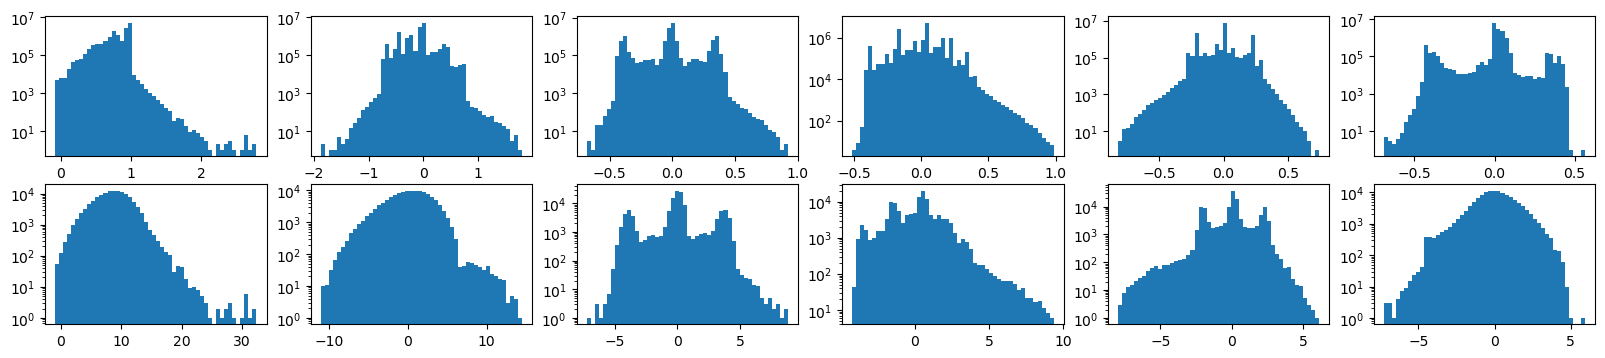

In [103]:
fig, axes = plt.subplots(2,6,figsize=(20,4))

for p in range(6):
    ax = axes[0,p]
    ax.hist(U_pc[:,p]*S[p],50)
    ax.set_yscale('log')

    ax = axes[1,p]
    ax.hist(U[:,p]*S[p],50)
    ax.set_yscale('log')

In [55]:
U_pc.shape

(14403500, 6)